In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=18)

Let $\mathcal{X}=\mathcal{X}(D,\mathbb{R}^{n_\mathcal{X}})$ and $\mathcal{Y}=\mathcal{Y}(D,\mathbb{R}^{n_\mathcal{Y}})$ be two Banach spaces, with $D\subset\mathbb{R}$ being a bounded domain and $n_\mathcal{X},n_\mathcal{Y}\in\mathbb{N}$.
We refer to the space $\mathcal{X}$ as the input space (e.g. space of initial conditions) and the space $\mathcal{Y}$ as the output space (e.g solution space of the PDE at time $T$).

Let $\mathcal{G}:\mathcal{X}\mapsto \mathcal{Y}$ be an operator that represents the solution operator of a PDE of interest.
The goal of this computer session is to approximate the operator $\mathcal{G}$ with the surrogate $\mathcal{N}:\mathcal{X}\to\mathcal{Y}$ from finite data of measurements of input and target function pairs

$$\{\bar{u}_{j}(x), u_{T,j}(x)\}_{j=1}^M$$

Moreover, we will consider the following PDE in the time-space domain $D_T = [0,T]\times[-1,1]$:
$$
u_t + 5(u^3 - u) = \epsilon u_{xx}, \quad \forall (t,x)\in D_T
$$
with $\epsilon=0.01$ and $T=1$. The equation is known with the name of Allen-Cahn equation. The dynamic of the system evolves in time from the initial condition $u(0,x)=\bar{u}(x)$, $x\in[-1,1]$, and $\bar{u}\in\mathcal{X}$.
We are interested in approximating the operator
$$
\mathcal{G}: \mathcal{X} \to \mathcal{Y}, \quad \mathcal{G}: \bar{u}(x) \mapsto u(T,x) = u_T(x)
$$
which maps the initial datum to the solution of the PDE at time $T=1$.


In [ ]:
import os

print("This data will download all the files required for the computer session."
      " You must have 'wget' installed for the downloads to work.")

folder_name = "data"
if os.path.isdir(folder_name):
    print("Folder Exists! Downloading there")
else:
    print("Creating folder data")
    os.mkdir(folder_name)
fnames = ["AC_data_input_new.npy", "AC_data_output_new.npy"]
for fid, fname in enumerate(fnames):
    print('Downloading file ' + fname + ':')
    url = "https://zenodo.org/record/8114457/files/" + fname
    cmd = f"wget --directory-prefix {folder_name} {url}"
    os.system(cmd)


This data will download all the files required for the computer session. You must have 'wget' installed for the downloads to work.
Folder Exists! Downloading there


--2023-07-18 16:49:20--  https://zenodo.org/record/8114457/files/AC_data_input_new.npy
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16000128 (15M) [application/octet-stream]
Saving to: ‘data/AC_data_input_new.npy.5’

     0K .......... .......... .......... .......... ..........  0% 2.75M 6s
    50K .......... .......... .......... .......... ..........  0%  821K 12s
   100K .......... .......... .......... .......... ..........  0% 1.95M 11s
   150K .......... .......... .......... .......... ..........  1% 10.7M 8s
   200K .......... .......... .......... .......... ..........  1% 15.2M 7s
   250K .......... .......... .......... .......... ..........  1% 20.1M 6s
   300K .......... .......... .......... .......... ..........  2% 14.5M 5s
   350K .......... .......... .......... .......... ..........  2% 19.6M 5s
   400K .......... .......... .........

Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8000128 (7.6M) [application/octet-stream]
Saving to: ‘data/AC_data_output_new.npy.5’

     0K .......... .......... .......... .......... ..........  0% 3.13M 2s
    50K .......... .......... .......... .......... ..........  1% 3.22M 2s
   100K .......... .......... .......... .......... ..........  1% 36.4M 2s
   150K .......... .......... .......... .......... ..........  2% 3.32M 2s
   200K .......... .......... .......... .......... ..........  3% 2.94M 2s
   250K .......... .......... .......... .......... ..........  3% 8.90M 2s
   300K .......... .......... .......... .......... ..........  4% 5.63M 2s
   350K .......... .......... .......... .......... ..........  5% 3.19M 2s
   400K .......... .......... .......... .......... ..........  5% 6.32M 2s
   450K .......... .......... .......... ..........

You are given with a set of input-output functions $\{\bar{u}_{j}(x), u_{T,j}(x)\}_{j=1}^M$, stored in the data files "AC_data_input_new.npy" and "AC_data_input_new.npy", respectively. Specifically, the file "AC_data_input_new.npy" contains a Numpy array of shape $M\times P\times 2$ ($M=1000$, $P=1000$),

$$
\text{input_data}[j, i, 0] = x_i, \quad \forall j=1,...,M
$$

$$
\text{input_data}[j, i, 1] = \bar{u}_{j}(x_i)
$$

On the other hand, the file "AC_data_input_new.npy" contains a Numpy array of shape $M\times P$ ($M=1000$, $P=1000$):

$$
\text{output_data}[j, i] = u_{T,j}(x_i)
$$

The data contained in the file will represent our "continuous" signal. We say continuous because it is sampled at a very fine grid ($P=1000$).

<br/><br/>

<img src="ImagesCEMRACS/data.png" width="1000">

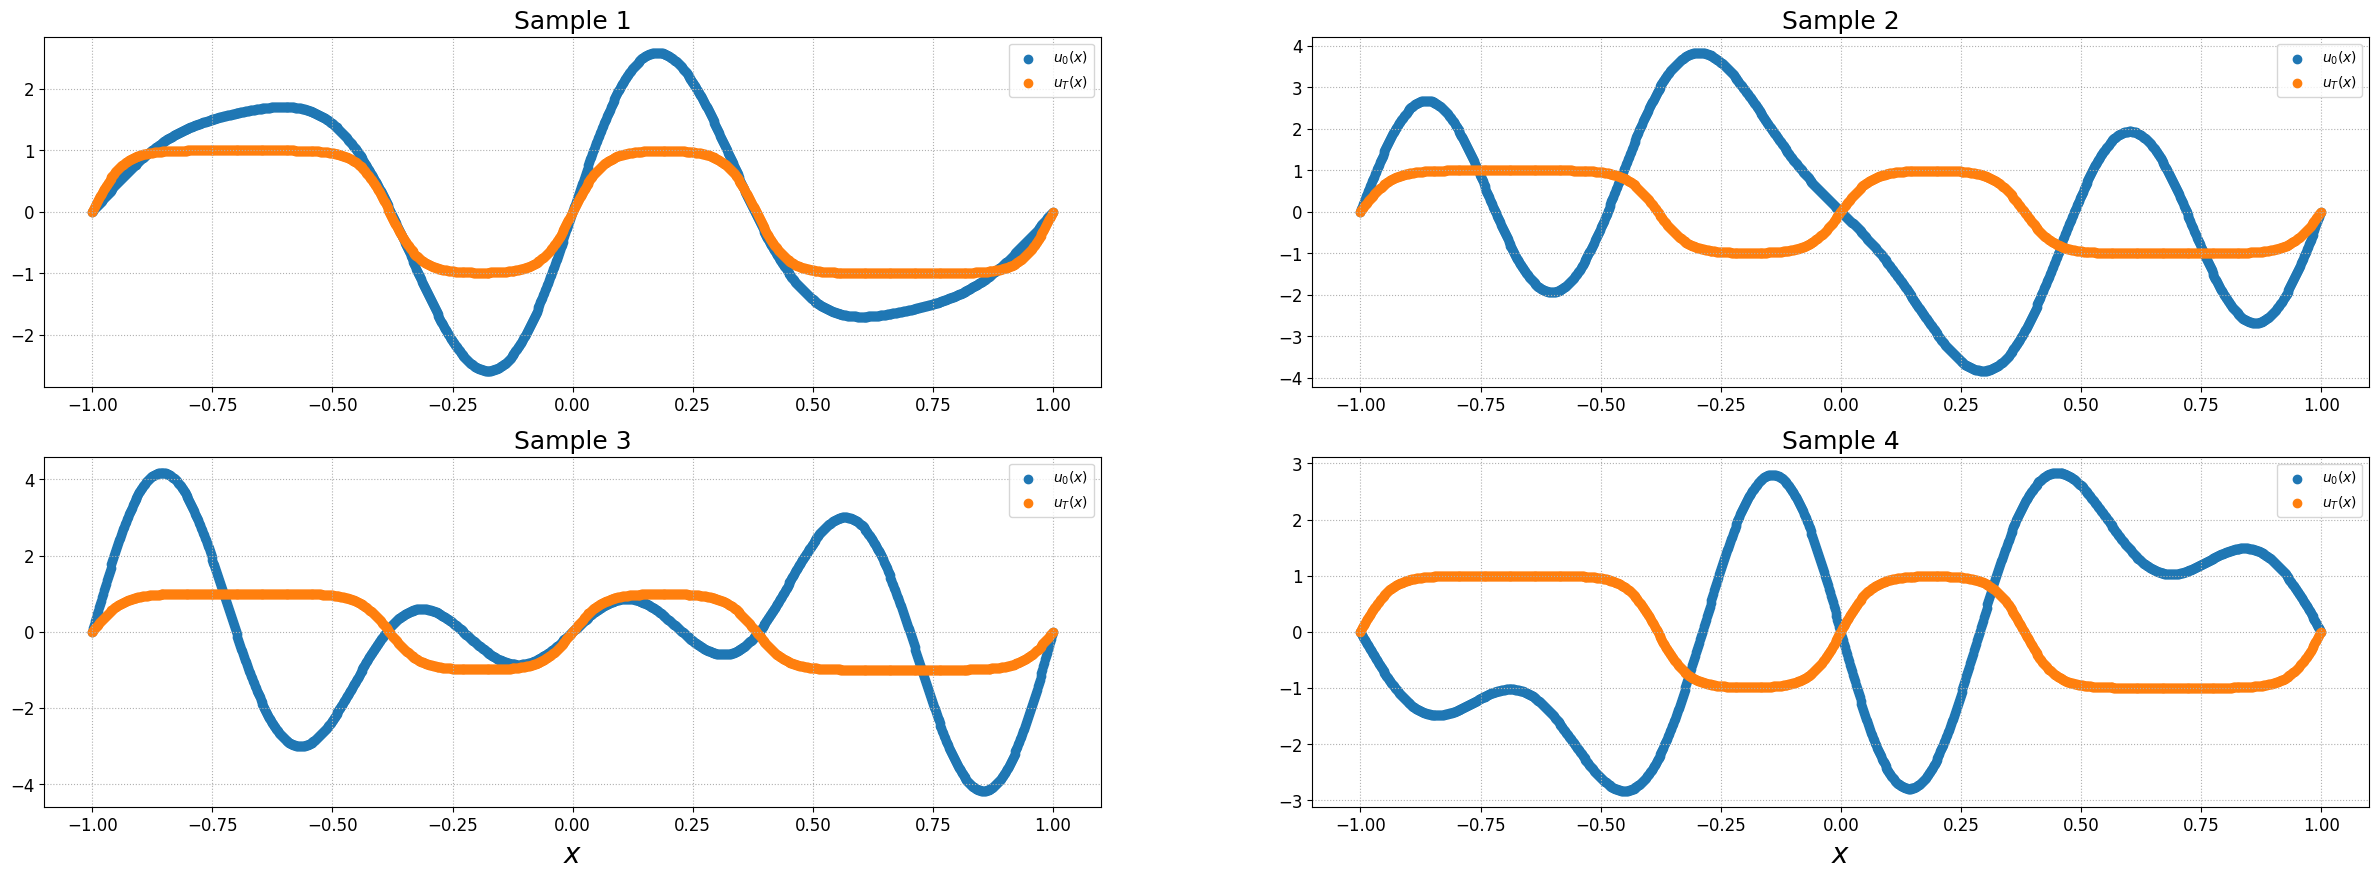

In [ ]:
# input_data and output_data contain all the input and output functions evaluated on a grid with 1000 points
input_data = torch.from_numpy(np.load("data/AC_data_input_new.npy")).type(torch.float32)  # Shape (1000, 1000, 2)
output_data = torch.from_numpy(np.load("data/AC_data_output_new.npy")).type(torch.float32)  # Shape (1000, 1000)

# input_data[:, :, 0] contains the values of the x coordinates where the input functions are evaluated
# input_data[:, :, 1] contains the values of the input functions at the given x coordinates
# output_data contains the values of the output functions at the given x coordinates (same as the coordinates where the input functions are evaluated)

# Plot 4 samples from the data
fig, axes = plt.subplots(2, 2, figsize=(30, 10), dpi=100)
axes[0, 0].grid(True, which="both", ls=":")
axes[0, 1].grid(True, which="both", ls=":")
axes[1, 0].grid(True, which="both", ls=":")
axes[1, 1].grid(True, which="both", ls=":")

axes[0, 0].scatter(input_data[0, :, 0], input_data[0, :, 1], label=r'$u_0(x)$')
axes[0, 0].scatter(input_data[0, :, 0], output_data[0, :], label=r'$u_T(x)$')

axes[0, 1].scatter(input_data[0, :, 0], input_data[1, :, 1], label=r'$u_0(x)$')
axes[0, 1].scatter(input_data[0, :, 0], output_data[0, :], label=r'$u_T(x)$')

axes[1, 0].scatter(input_data[0, :, 0], input_data[2, :, 1], label=r'$u_0(x)$')
axes[1, 0].scatter(input_data[0, :, 0], output_data[0, :], label=r'$u_T(x)$')

axes[1, 1].scatter(input_data[0, :, 0], input_data[3, :, 1], label=r'$u_0(x)$')
axes[1, 1].scatter(input_data[0, :, 0], output_data[0, :], label=r'$u_T(x)$')

axes[0, 0].set(title="Sample 1")
axes[0, 1].set(title="Sample 2")
axes[1, 0].set(xlabel=r'$x$', title="Sample 3")
axes[1, 1].set(xlabel=r'$x$', title="Sample 4")
axes[0, 0].legend()
axes[0, 1].legend()
axes[1, 0].legend()
axes[1, 1].legend()

In [ ]:
# Concatenate the output functions to the coordinates x, so that we have a tensor with the same shape as the input
output_data = torch.cat((input_data[:, :, 0].unsqueeze(-1), output_data.unsqueeze(-1)), -1)

The first step to construct an approximate operator $\mathcal{G}^\ast$ is to suitably *encode* the input and output functions (to a lower dimensional space), in order to be able to process them with a computer.
Let us define the input and output *encoding operator*
$$
     \mathcal{E}:\mathcal{Z}\mapsto\mathbb{R}^m,
$$
where $\mathcal{Z}$ is a given function space (for instance the input or the output function spaces $\mathcal{X}$, $\mathcal{Y}$) and, $m$ is the chosen *encoding dimensions*. In this case $m\ll P$.

#### Exercises
- Implement the grid_sensor_encoding member of the class Encoding which evaluate the function $f$ at given sensor points: $\mathcal{E}(f) = (f(x_1),\dots,f(x_N))$, where $x_1, x_2, ..., x_N$ are *random* points
- Implement the grid_sensor_encoding member of the class Encoding which evaluate the function $f$ at given sensor points: $\mathcal{E}(f) = (f(x_1),\dots,f(x_N))$, where $x_1, x_2, ..., x_N$ are *equispaced* points
- Implement the fourier_encoding member of the class Encoding which compute the Fourier coefficients of the function $f$.


In [ ]:
class Encoding(nn.Module):

    def __init__(self, encoding_dimension):
        super(Encoding, self).__init__()
        '''
        :param encoding_dimensions: encoding dimension m
        '''
        self.encoding_dimension = encoding_dimension

    def random_sensor_encoding(self, functions):
        '''
        :param functions: this tensor represents a batch of size M of the continuous functions $\{u_{j}(x)\}_{j=1}^M$.
        On a computer we represent a continuous function through a highly sampled discrete signal.
        Therefore, functions is a tensor of shape MxPx2, where P=1000 is the length of the highly-sampled function,
        and functions[j, i, 0] = x_i and functions[j, i, 1] = u_{j}(x_i),
        with x_1, x_2,...,x_i,...,x_P being the coordinates where the functions are sampled
        :return: encoding_coordinates, encoded_functions.
        encoding_coordinates: a tensor of shape (m,), (with m=encoding_dimension), corresponding to the discrete input coordinates, encoding_coordinates[i] = x_i, (in this case the random sensor points coordinates).
        encoded_functions: tensors of shape Mxm, corresponding to the discrete encoded functions encoded_functions[j,i]=u_{j}(x_i).
        '''
        M = functions.shape[0]
        P = functions.shape[1]
        np.random.seed(0)

        # TODO: implement grid encoding
        encoding_coordinates = torch.zeros((m,))
        encoded_functions = torch.zeros((M, m))
        return encoding_coordinates, encoded_functions

    def grid_sensor_encoding(self, functions):
        '''
        :param functions: this tensor represents a batch of size M of the continuous functions $\{u_{j}(x)\}_{j=1}^M$.
        On a computer we represent a continuous function through a highly sampled discrete signal.
        Therefore, functions is a tensor of shape MxPx2, where P=1000 is the length of the highly-sampled function,
        and functions[j, i, 0] = x_i and functions[j, i, 1] = u_{j}(x_i),
        with x_1, x_2,...,x_i,...,x_P being the coordinates where the functions are sampled
        :return: encoding_coordinates, encoded_functions.
        encoding_coordinates: a tensor of shape (m,), (with m=encoding_dimension), corresponding to the discrete input coordinates, encoding_coordinates[i] = x_i, (in this case the equispaced sensor points coordinates).
        encoded_functions: tensors of shape Mxm, corresponding to the discrete encoded functions encoded_functions[j,i]=u_{j}(x_i).
        '''
        M = functions.shape[0]
        P = functions.shape[1]
        # TODO: implement grid encoding
        encoding_coordinates = torch.zeros((m,))
        encoded_functions = torch.zeros((M, m))
        return encoding_coordinates, encoded_functions

    def fourier_encoding(self, functions):
        '''
        :param functions: this tensor represents a batch of size M of the continuous functions $\{u_{j}(x)\}_{j=1}^M$.
        On a computer we represent a continuous function through a highly sampled discrete signal.
        Therefore, functions is a tensor of shape MxPx2, where P=1000 is the length of the highly-sampled function,
        and functions[j, i, 0] = x_i and functions[j, i, 1] = u_{j}(x_i),
        with x_1, x_2,...,x_i,...,x_P being the coordinates where the functions are sampled
        :return: encoding_coordinates, encoded_functions.
        encoding_coordinates: a tensor of shape m, (with m=encoding_dimension), corresponding to the discrete input coordinates, encoding_coordinates[i] = f_i, (in this case the first m frequencies).
        encoded_functions: tensors of shape MxN, corresponding to the first $m$ Fourier coefficients at the encoded_functions[j,i,0]=Real(F[u_{j}](f_i)), encoded_functions[j,i,1]=Imag(F[u_{j}](f_i)) where F is the discrete FT.
        '''
        M = functions.shape[0]
        P = functions.shape[1]
        # Nyquist frequency (max resolvable frequency)
        f_nyquist = P // 2 + 1

        # Use https://pytorch.org/docs/stable/generated/torch.fft.rfft.html#torch.fft.rfft to compute the Fourier coefficients
        # TODO: implement Fourier encoding
        frequencies = torch.zeros((m,))
        encoded_functions = torch.zeros((M, m, 2))

        return frequencies, encoded_functions

    def forward(self, functions, which):
        if which == "Random":
            return self.random_sensor_encoding(functions)
        elif which == "Grid":
            return self.grid_sensor_encoding(functions)
        elif which == "Fourier":
            return self.fourier_encoding(functions)
        else:
            raise ValueError(r'which must be one among "Random", "Grid", and "Fourier"')

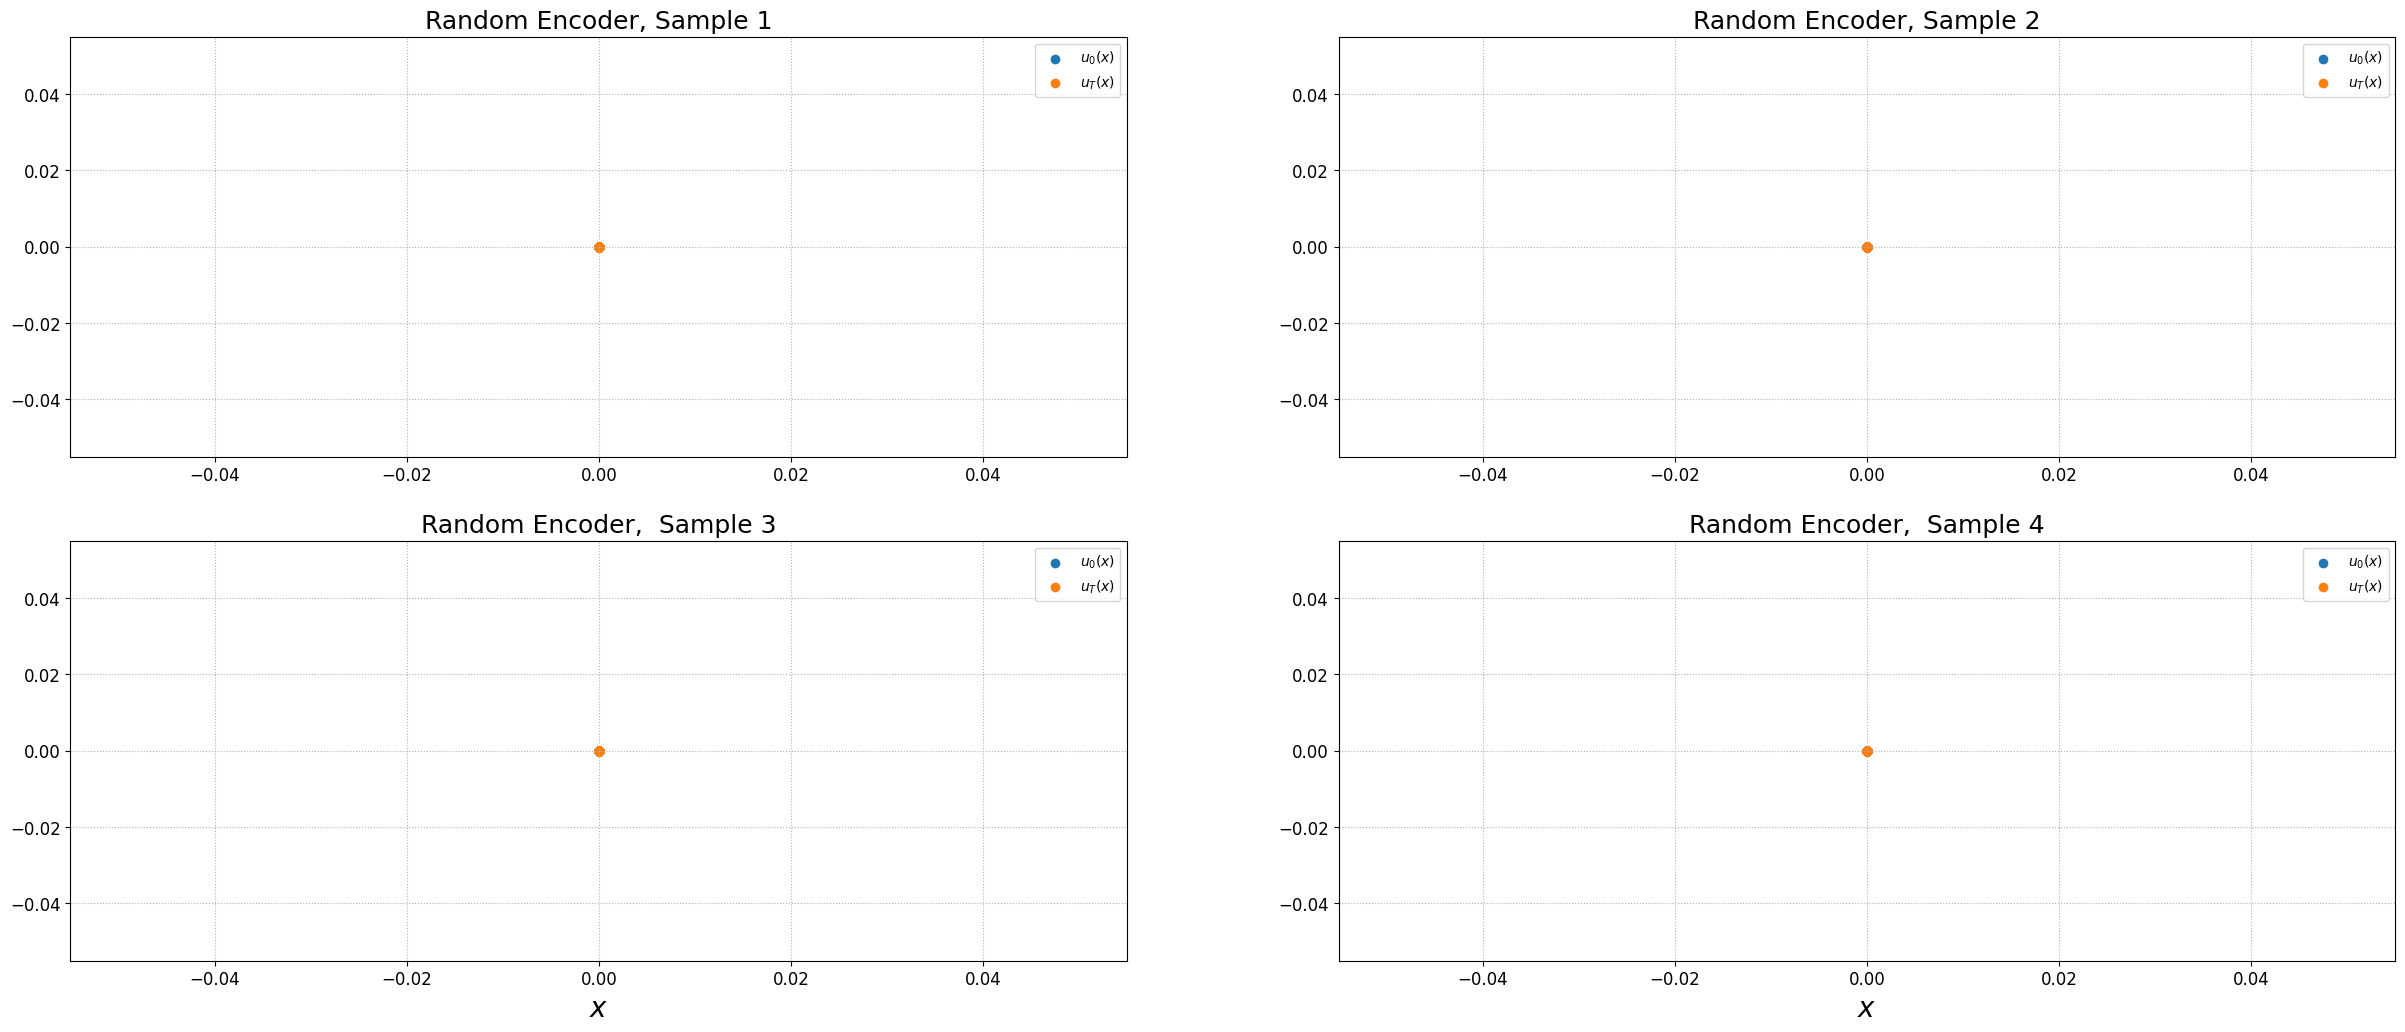

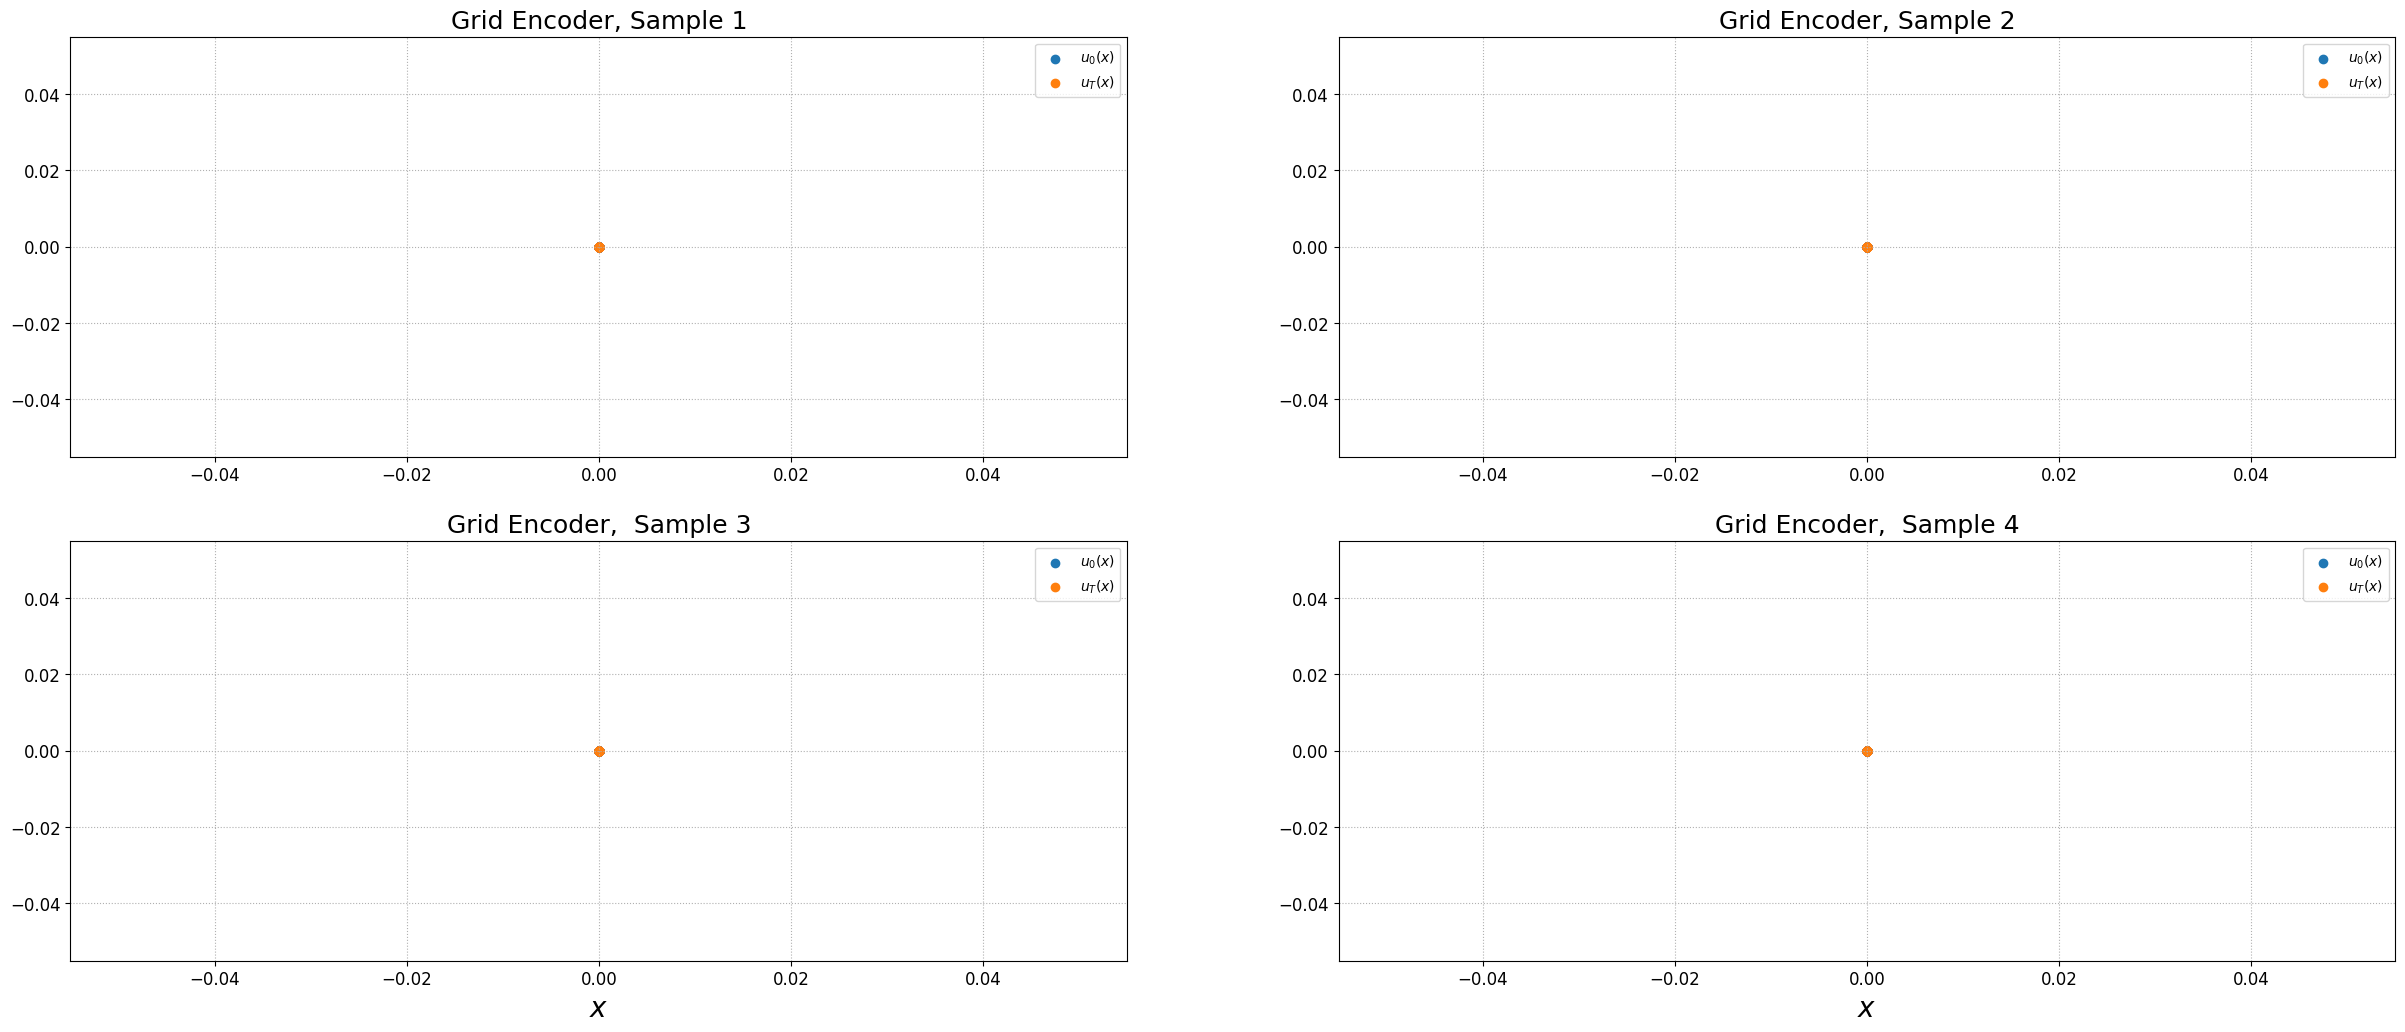

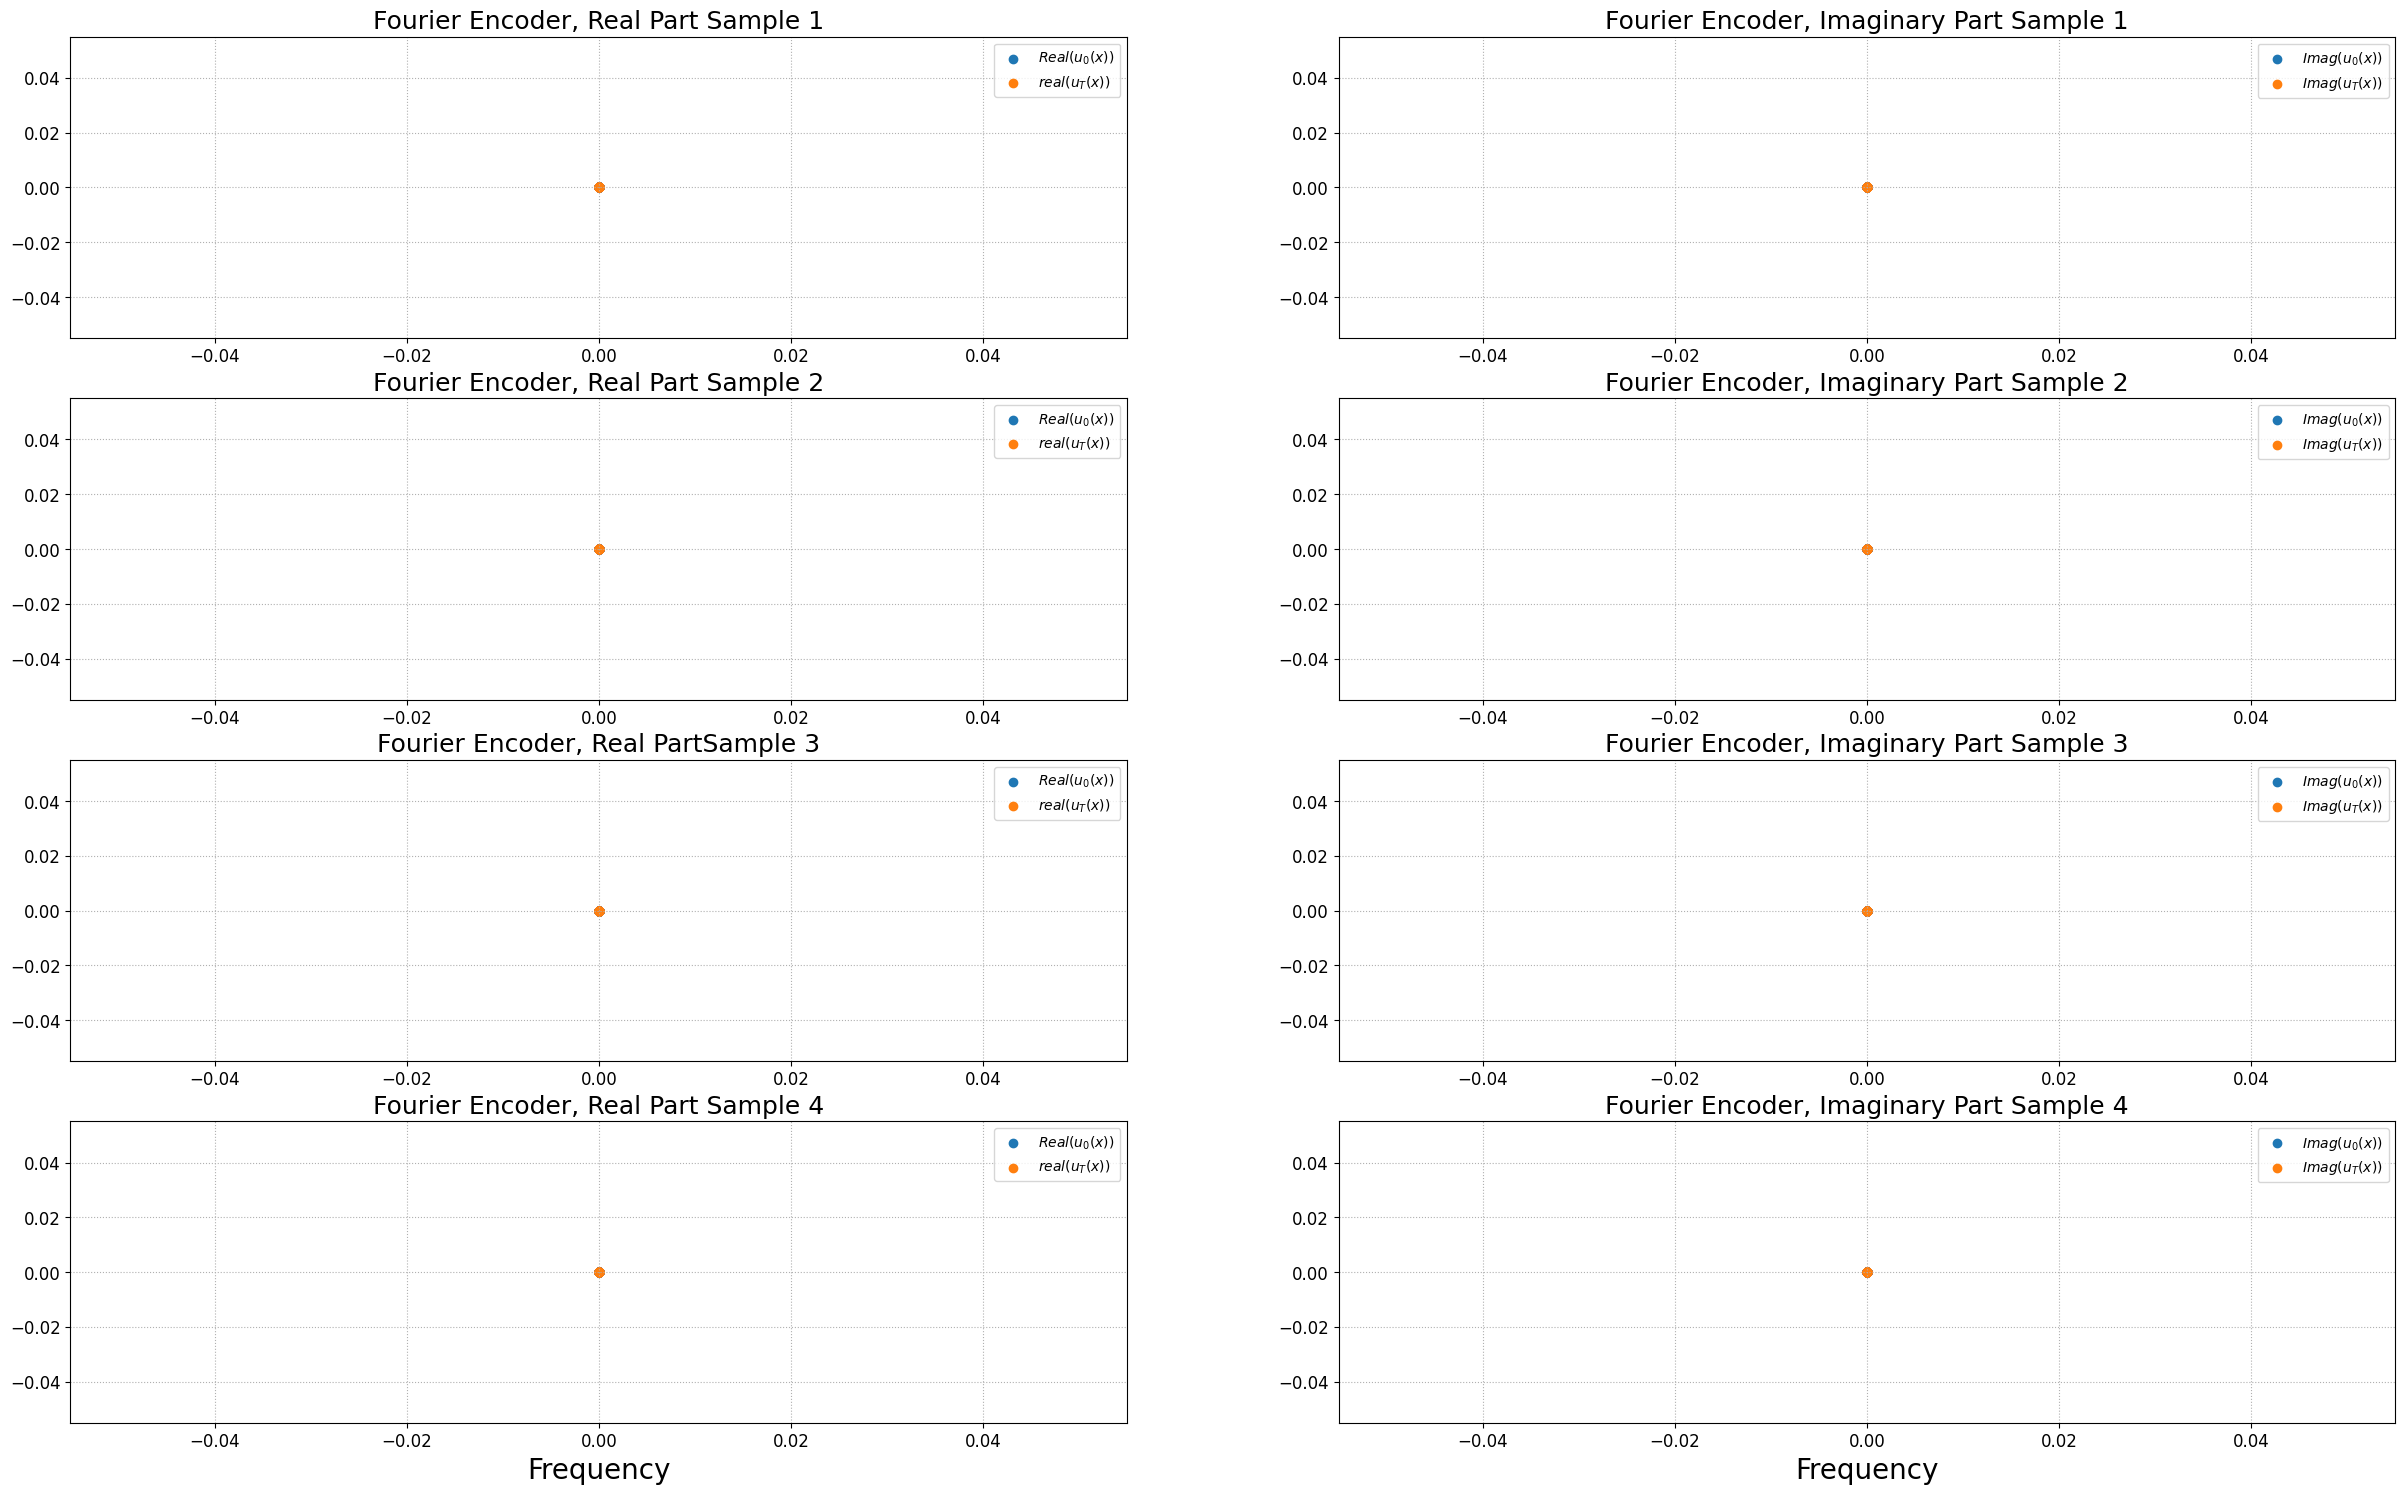

In [ ]:
# Test the implementation of the encoding by plotting the encoded inputs and outputs
m = 50  # This is the encoding dimension
encoding_operator = Encoding(encoding_dimension=m)

for which_enconder in ["Random", "Grid", "Fourier"]:
    encoding_coordinates_input, encoding_function_input = encoding_operator(input_data, which_enconder)
    encoding_coordinates_output, encoding_function_output = encoding_operator(output_data, which_enconder)
    # Set of coordinates where input functions are evaluated (variable x in the notes)

    if which_enconder != "Fourier":
        fig, axes = plt.subplots(2, 2, figsize=(30, 12))
        axes[0, 0].grid(True, which="both", ls=":")
        axes[0, 1].grid(True, which="both", ls=":")
        axes[1, 0].grid(True, which="both", ls=":")
        axes[1, 1].grid(True, which="both", ls=":")

        axes[0, 0].scatter(encoding_coordinates_input, encoding_function_input[0], label=r'$u_0(x)$')
        axes[0, 0].scatter(encoding_coordinates_input, encoding_function_output[0], label=r'$u_T(x)$')

        axes[0, 1].scatter(encoding_coordinates_input, encoding_function_input[1], label=r'$u_0(x)$')
        axes[0, 1].scatter(encoding_coordinates_input, encoding_function_output[1], label=r'$u_T(x)$')

        axes[1, 0].scatter(encoding_coordinates_input, encoding_function_input[2], label=r'$u_0(x)$')
        axes[1, 0].scatter(encoding_coordinates_input, encoding_function_output[2], label=r'$u_T(x)$')

        axes[1, 1].scatter(encoding_coordinates_input, encoding_function_input[3], label=r'$u_0(x)$')
        axes[1, 1].scatter(encoding_coordinates_input, encoding_function_output[3], label=r'$u_T(x)$')

        axes[0, 0].set(title=which_enconder + " Encoder, Sample 1")
        axes[0, 1].set(title=which_enconder + " Encoder, Sample 2")

        axes[1, 0].set(xlabel="$x$", title=which_enconder + " Encoder,  Sample 3")
        axes[1, 1].set(xlabel="$x$", title=which_enconder + " Encoder,  Sample 4")

        axes[0, 0].legend()
        axes[0, 1].legend()
        axes[1, 0].legend()
        axes[1, 1].legend()
    else:
        fig, axes = plt.subplots(4, 2, figsize=(30, 18))
        axes[0, 0].grid(True, which="both", ls=":")
        axes[0, 1].grid(True, which="both", ls=":")
        axes[1, 0].grid(True, which="both", ls=":")
        axes[1, 1].grid(True, which="both", ls=":")
        axes[2, 0].grid(True, which="both", ls=":")
        axes[2, 1].grid(True, which="both", ls=":")
        axes[3, 0].grid(True, which="both", ls=":")
        axes[3, 1].grid(True, which="both", ls=":")
        axes[0, 0].scatter(encoding_coordinates_input, encoding_function_input[0, :, 0], label=r'${Real}(u_0(x))$')
        axes[0, 0].scatter(encoding_coordinates_input, encoding_function_output[0, :, 0], label=r'${real}(u_T(x))$')

        axes[0, 1].scatter(encoding_coordinates_input, encoding_function_input[0, :, 1], label=r'${Imag}(u_0(x))$')
        axes[0, 1].scatter(encoding_coordinates_input, encoding_function_output[0, :, 1], label=r'${Imag}(u_T(x))$')

        axes[1, 0].scatter(encoding_coordinates_input, encoding_function_input[1, :, 0], label=r'${Real}(u_0(x))$')
        axes[1, 0].scatter(encoding_coordinates_input, encoding_function_output[1, :, 0], label=r'${real}(u_T(x))$')

        axes[1, 1].scatter(encoding_coordinates_input, encoding_function_input[1, :, 1], label=r'${Imag}(u_0(x))$')
        axes[1, 1].scatter(encoding_coordinates_input, encoding_function_output[1, :, 1], label=r'${Imag}(u_T(x))$')

        axes[2, 0].scatter(encoding_coordinates_input, encoding_function_input[2, :, 0], label=r'${Real}(u_0(x))$')
        axes[2, 0].scatter(encoding_coordinates_input, encoding_function_output[2, :, 0], label=r'${real}(u_T(x))$')

        axes[2, 1].scatter(encoding_coordinates_input, encoding_function_input[2, :, 1], label=r'${Imag}(u_0(x))$')
        axes[2, 1].scatter(encoding_coordinates_input, encoding_function_output[2, :, 1], label=r'${Imag}(u_T(x))$')

        axes[3, 0].scatter(encoding_coordinates_input, encoding_function_input[3, :, 0], label=r'${Real}(u_0(x))$')
        axes[3, 0].scatter(encoding_coordinates_input, encoding_function_output[3, :, 0], label=r'${real}(u_T(x))$')

        axes[3, 1].scatter(encoding_coordinates_input, encoding_function_input[3, :, 1], label=r'${Imag}(u_0(x))$')
        axes[3, 1].scatter(encoding_coordinates_input, encoding_function_output[3, :, 1], label=r'${Imag}(u_T(x))$')

        axes[0, 0].set(title=which_enconder + " Encoder, Real Part Sample 1")
        axes[0, 1].set(title=which_enconder + " Encoder, Imaginary Part Sample 1")

        axes[1, 0].set(title=which_enconder + " Encoder, Real Part Sample 2")
        axes[1, 1].set(title=which_enconder + " Encoder, Imaginary Part Sample 2")

        axes[2, 0].set(title=which_enconder + " Encoder, Real PartSample 3")
        axes[2, 1].set(title=which_enconder + " Encoder, Imaginary Part Sample 3")

        axes[3, 0].set(xlabel="Frequency", title=which_enconder + " Encoder, Real Part Sample 4")
        axes[3, 1].set(xlabel="Frequency", title=which_enconder + " Encoder, Imaginary Part Sample 4")

        axes[0, 0].legend()
        axes[0, 1].legend()
        axes[1, 0].legend()
        axes[1, 1].legend()

        axes[2, 0].legend()
        axes[2, 1].legend()

        axes[3, 0].legend()
        axes[3, 1].legend()


### Multi Layer Perceptron
Given an input $x \in D \subset R^n$, a feedforward neural network (or Multi Layer Perceptron) transforms it to an output $u_\theta(x)\in R^m$, through a layer of units (neurons) which compose of either affine-linear maps between units (in successive layers) or scalar non-linear activation functions within units, resulting in the representation,

$$u_{\theta}(x) = C_K \circ \sigma \circ C_{K-1}\ldots \ldots \ldots \circ \sigma \circ C_2 \circ \sigma \circ C_1(x).$$

Here, $\circ$ refers to the composition of functions and $\sigma $ is a scalar (non-linear) activation function. For any $1 \leq k \leq K$, we define

$$
C_k z_k = W_k z_k + b_k, \quad {\rm for} ~ W_k \in R^{d_{k+1} \times d_k}, z_k \in R^{d_k}, b_k \in R^{d_{k+1}}.
$$

We also denote, 
$$
\theta = \{W_k, b_k\}, \quad \forall~ 1 \leq k \leq K,
$$
to be the concatenated set of (tunable) weights for our network.

We define:
- $K$: number of hidden layers
- $d_{k+1}=d_{k}=\bar{d}$, for all $k=1,...,K$: number of neurons

<br/><br/>

<img src="ImagesCEMRACS/ffnn.png" width="500" height="200">


In [23]:
class MLP(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers_=4, neurons_=20, retrain_seed_=42):
        super(MLP, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons_
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers_
        # Activation function
        self.activation = nn.LeakyReLU()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed_
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

## DeepONet

The first operator learning architecture we are gping to see is *DeepONet*, which belongs to the class of models known as *operator networks*.
Let $D \subset \mathbb{R}, D' \subset \mathbb{R}$, and $\mathcal{X} = \mathcal{X}(D, \mathbb{R})$ and $\mathcal{Y} = \mathcal{Y}(D', \mathbb{R})$ be suitable function spaces. Then, a *DeepONet* is the operator, $\mathcal{N}^{DON}: \mathcal{X} \to \mathcal{Y}$, given by

$$
\mathcal{N}^{DON}(\bar{u})(y) = \sum_{k=1}^p \beta_k(\bar{u}) \tau_k(y),
\quad \bar{u} \in \mathcal{X}, \; y \in D',
$$

where the *branch-net* ${\beta}$ is a neural network that maps an encoding $\mathcal{E}(\bar{u})$ of the input function $\bar{u}$ to $\mathbb{R}^p$:

$$
{\beta}: \mathbb{R}^m \to \mathbb{R}^p, ~\mathcal{E}(\bar{u}) \mapsto (\beta_1(\mathcal{E}(\bar{u})),\dots, \beta_p(\mathcal{E}(\bar{u})),
$$

and the *trunk-net* ${\tau}(y) = (\tau_1(y),\dots, \tau_p(y))$ is another neural network mapping,

$$
{\tau}: D' \to \mathbb{R}^p, \quad y\mapsto (\tau_1(y),\dots, \tau_p(y)).
$$

Thus, a DeepONet combines the branch net (as coefficient functions) and trunk net (as basis functions) to create a mapping between functions.

<br/><br/>

<img src="ImagesCEMRACS/dona.png" width="700" >


<br/><br/>

<img src="ImagesCEMRACS/donetb.png" width="850">


### Dataset

We assume that both the branch-net and trunk-net are MLPs. The dataset for DeepONet is given by

$$
\mathcal{S}^{DON} = \{ (\mathbf{y}, ~ \mathcal{E}(\bar{u}_{j}), ~u_{T,j}(\mathbf{y})), ~ j=1,...,M\}, \quad y\in D'= D
$$

We will assume for all the experiments  that $\mathbf{y}=\{y_1, y_2, ..., y_N\}$ are equi-spaced grid points: $y_i -{y_{i-1}}=\Delta y$, $\forall i=1,...,N$

Let us start by consider encoding of the input functions at randomly distributed sensor points:

$$
\mathcal{E}(\bar{u}_{j}) = (\bar{u}(x_1),\dots,\bar{u}(x_m))
$$
with $\{ x_1, x_2, ..., x_m \}$ uniformly distributed random points.

In PyTorch $\mathbf{y}$ is tensor of shape (N,1), the encoded input functions $\mathcal{E}(\bar{u}_{j}), ~ j=1,...,M$ are collected in a tensor ($M\times m$) and the output function $u_{T,j}(y), ~ j=1,...,M$ in a tensor of shape ($M\times N
$). Keep in mind that $N$ and $m$ can be different. However, we will consider the same encoding dimensions $m=N$ of inputs and outputs.

Observe that we construct batches only with respect to the function samples. Instead, during the training we give as input to the trunk the *entire* tensor $\mathbf{y}$ at every training step!



#### Exercises
- Implement  the member forward of the class DeepONet. The function, takes as input u_, which is fed to the branch-net, and y_ which is instead fed to the trunk-net. u_ has shape (B, m), with $B\leq M$, being the batch size, and y_ a tensor of shape (N,1), corresponding to $\textbf{y}=\{y_1, y_2, ..., y_N\}$. The output has a shape (B, N).


In [24]:
class DeepOnet(nn.Module):
    def __init__(self, branch, trunk):
        super(DeepOnet, self).__init__()
        self.branch = branch
        self.trunk = trunk

    def forward(self, u_, y_):
        # TODO: Implement the forward function
        # u_ has shape (B, m)
        # y_ ha shape (N,1), N=m
        B = u_.shape[0]
        N = y_.shape[0]

        output = torch.zeros((B, N))
        return output

## DeepONet with Random Encoding

In [25]:
print("Using encoding at random sensors for the input functions")
# Encoding coordinates are not needed by DeepONet
_, random_encoding_input_donet = encoding_operator(input_data, "Random")
print("Shape of the encoded input tensor: ", random_encoding_input_donet.shape)

# TODO: encode the output functions at grid points
# We assume that the output function is evaluated at grid points {y_1, y_2, ..., y_N}
grid_encoding_coordinates_donet, grid_encoding_output = encoding_operator(output_data, "Grid")
print("Shape of the the encoded output tensor: ", grid_encoding_output.shape)
grid_encoding_coordinates_donet = grid_encoding_coordinates_donet.unsqueeze(-1)  # this is what called y
print("Shape of the coordinates y where to evaluate the output functions: ", grid_encoding_coordinates_donet.shape)

# Split train-testing data and create the corresponding data loaders for the training
n_train = 500
batch_size = 20

random_encoding_input_donet_train = random_encoding_input_donet[:n_train, :]
random_encoding_input_donet_test = random_encoding_input_donet[n_train:, :]

grid_encoding_output_train = grid_encoding_output[:n_train, :]
grid_encoding_output_test = grid_encoding_output[n_train:, :]

# Define the dataloader
random_training_set_don = DataLoader(TensorDataset(random_encoding_input_donet_train, grid_encoding_output_train), batch_size=batch_size, shuffle=True)
random_testing_set_don = DataLoader(TensorDataset(random_encoding_input_donet_test, grid_encoding_output_test), batch_size=n_train, shuffle=False)


Using encoding at random sensors for the input functions
Shape of the encoded input tensor:  torch.Size([1000, 50])
Shape of the the encoded output tensor:  torch.Size([1000, 50])
Shape of the coordinates y where to evaluate the output functions:  torch.Size([50, 1])


### Exercise
Define the trunk and the branch for a DeepONet with Random encoding

In [26]:
n_hidden_layers = 4
neurons = 50
retrain_seed = 42

p = 25  # number of basis functions

#TODO: Define BranchNet and TrunkNet as MLPs
branch_net = None
trunk_net = None

In [27]:
# Initialize the model
donet_random = DeepOnet(branch_net, trunk_net)

## DeepONet with Grid Encoding

In [28]:
print("Using encoding at grid sensors for the input functions")
# TODO: encode the input functions at grid points
grid_encoding_coordinates_don, grid_encoding_input_donet = encoding_operator(input_data, "Grid")
print("Shape of the encoded input tensor: ", random_encoding_input_donet.shape)

# Split train-testing data and create the corresponding data loaders for the training
grid_encoding_input_donet_train = grid_encoding_input_donet[:n_train, :]
grid_encoding_input_donet_test = grid_encoding_input_donet[n_train:, :]

# Define the dataloader
grid_training_set_don = DataLoader(TensorDataset(grid_encoding_input_donet_train, grid_encoding_output_train), batch_size=batch_size, shuffle=True)
grid_testing_set_don = DataLoader(TensorDataset(grid_encoding_input_donet_test, grid_encoding_output_test), batch_size=n_train, shuffle=False)

Using encoding at grid sensors for the input functions
Shape of the encoded input tensor:  torch.Size([1000, 50])


### Exercise
Define the trunk and the branch for a DeepONet with Grid encoding

In [ ]:
#TODO: Define BranchNet and TrunkNet as MLPs
branch_net = None
trunk_net = None

In [ ]:
# Initialize the model
donet_grid = DeepOnet(branch_net, trunk_net)

## DeepONet with Fourier Encoding

In [30]:
print("Using encoding given by the Fourier coefficients of the input functions")
# TODO: encode the input functions at grid pints
_, fourier_encoding_input_donet = encoding_operator(input_data, "Fourier")
print("Shape of the encoded input tensor: ", fourier_encoding_input_donet.shape)
# reshape the input from 1000xmx2 (real and imaginary part) to 1000x(2*m)
fourier_encoding_input_donet = fourier_encoding_input_donet.reshape(fourier_encoding_input_donet.shape[0], 2 * m)
print("Shape after reshaping of the encoded input tensor: ", fourier_encoding_input_donet.shape)

# Split train-testing data and create the corresponding data loaders for the training
fourier_encoding_input_donet_train = fourier_encoding_input_donet[:n_train, :]
fourier_function_input_donet_test = fourier_encoding_input_donet[n_train:, :]

# Define the dataloader
fourier_training_set_don = DataLoader(TensorDataset(fourier_encoding_input_donet_train, grid_encoding_output_train), batch_size=batch_size, shuffle=True)
fourier_testing_set_don = DataLoader(TensorDataset(fourier_function_input_donet_test, grid_encoding_output_test), batch_size=n_train, shuffle=False)


Using encoding given by the Fourier coefficients of the input functions
Shape of the encoded input tensor:  torch.Size([1000, 50, 2])
Shape after reshaping of the encoded input tensor:  torch.Size([1000, 100])


### Exercise
Define the trunk and the branch for a DeepONet with Fourier encoding

In [ ]:
#TODO: Define BranchNet and TrunkNet as MLPs
branch_net = None
trunk_net = None

In [ ]:
# Initialize the model
donet_fourier = DeepOnet(branch_net, trunk_net)

## Fourier Neural Operator
Recall the general structure of a Neural Operator $\mathcal{N}^{NO}$:

$$
\mathcal{N}^{NO}(\bar{u})(x)  = Q \circ \mathcal{L}_T \circ \dots \mathcal{L}_t \circ \dots \circ \mathcal{L}_1\circ R(v_0)(x)
$$

where $R: \mathbb{R}^{d_u} \to  \mathbb{R}^{d_v}, \quad R: v_0 \mapsto v_1$ is linear or nonlinear transformation of the encoded input, $\mathcal{L}_t$, $t=1,...,T$ are integral layers and $Q:\mathbb{R}^{d_v} \to  \mathbb{R}$ is a projection to the original space. The integral layer applied to $v_t:D \to \mathbb{R}^{d_v}$ is generally defined as:

$$
v_{t+1}(x) = \mathcal{L}_t(v_{t})(x) = \sigma\left(W_t v_t(x) + B_t(x) + \mathcal{K}_t(v_t)(x) \right), \quad \mathcal{K}(v_t)(x) = \int_D \kappa_{t}(x,y)v_t dy, \quad \forall x \in D
$$

where $W_t :\mathbb{R}^{d_v}\to\mathbb{R}^{d_v}$ is a *local linear operators* and $B_t:D \to \mathbb{R}^{d_v}$ is a *bias function*, and $\kappa_{t}: D\times D \to \mathbb{R}^{d_v}\times\mathbb{R}^{d_v}$ being a *kernel function*.

Observe that in this case, we called the input $v_0$, and not $\bar{u}$. This is not a mistake. In fact, in the original paper, the input is the concatenation of the coordinates $\textbf{x} =\{x_i\}_{i=1}^m$ where the input is defined and the actual input function $\{\bar{u}(x_i)\}_{i=1}^m$. So in this case, observe that $d_u=2$.


<br/><br/>

<img src="ImagesCEMRACS/fnoinp.png" width="850">

<br/><br/>


In the case of FNO, by letting $\kappa_{t}(x,y) = \kappa_{t}(x -y)$ and exploiting the convolution theorem,  the integral kernel can be explicitly formulated as:

$$
\mathcal{K}_t(v_t) = \mathcal{F}^{-1} \left[\mathcal{F}[\kappa_t](k) \cdot \mathcal{F} [v_t](k) \right]
$$

where $\mathcal{F}[v]$ represents the Fourier transform of a function $v$, and $\mathcal{F}^{-1}[v]$ its inverse.

In the discrete setting:
- the Fourier transform is replaced by the Fourier coefficients $\mathcal{F}_m [v_t](k)$ of the discrete Fourier transform (DFT) of the function $v_t(x)$, and we truncate the corresponding modes up to $k_{modes}$ (all the remaining modes are set to zero!). Since we use FFT algorithm to compute the Fourier coefficients, for FNO we consider only encoding at grid points $\textbf{x} =\{x_i\}_{i=1}^m$.
- the DFT  of $\kappa_t$ at the frequency $k$, $\mathcal{F}_m[\kappa_t](k)$, is parameterized as complex-valued ($d_v \times d_v$)-tensors $P_t(k)\in\mathbb{C}^{ d_v\times d_v}$, for all $k=1,...,k_{modes}$.

<br/><br/>

<img src="ImagesCEMRACS/FNO1.png" width="750">

<br/><br/>


### Dataset

The dataset for FNO is given by

$$
\mathcal{S}^{FNO} = \{(\bar{u}_{j}(\textbf{x}), ~u_{T,j}(\textbf{x})), ~ j=1,...,M\}, \quad \textbf{x} =\{x_i\}_{i=1}^m, ~\text{being Cartesian grid points}
$$

Observe that since we use FFT algorithm we are constrained to grid points. We do not bother about concatenating the input functions to the coordinates to get the tensors $v_{0,j}$ beforehand. This is done in the forward function of FNO1d.


In [32]:
print("Using encoding at grid sensors for the input functions")
grid_encoding_coordinates_fno, grid_encoding_input_fno = encoding_operator(input_data, "Grid")

grid_encoding_input_fno_train = grid_encoding_input_fno[:n_train]
grid_encoding_input_fno_test = grid_encoding_input_fno[n_train:]

training_set_fno = DataLoader(TensorDataset(grid_encoding_input_fno_train, grid_encoding_output_train), batch_size=batch_size, shuffle=True)
testing_set_fno = DataLoader(TensorDataset(grid_encoding_input_fno_test, grid_encoding_output_test), batch_size=n_train, shuffle=False)


Using encoding at grid sensors for the input functions


### Data Structure and Implementation

In terms of data structures:
- the input to the linear function $R$ (first operation in FNO) is a tensor of shape $(M\times m \times 2)$, where the first channel corresponds to the coordinates $\textbf{x}$ and the second to the input function $\bar{u}(\textbf{x})$. See picture above. The output $v_1$ is a tensor of shape $(M\times m \times d_v)$.
- the functions $v_t$ are represented by tensors of shape $(M\times d_v \times m)$. In the code the last two axes of the tensor $v_1$, output of the transformation $R$ are permuted in order to compute the DFT: $(M\times m \times d_v) \to (M\times d_v\times m)$. Only before applying the transformation $Q$, the axes are permuted back to $(M\times m \times d_v)$.
- the DFT is computed through the function torch.fft.rfft and, applied to a tensor $(M\times d_v\times m)$ and returns a tensor of shape $(M\times d_v\times K)$, where $K$ is the total number of modes $k_{modes}<K$.
- the output of FNO is a tensor of shape $M\times m$
- the ($d_v \times d_v$)-complex-valued-tensors $P_t(k)\in\mathbb{C}^{ d_v\times d_v}$, $k=1,...,k_{modes}$ parametrizing the kernel, are collected together to obtain a ($d_v \times d_v \times k_{modes}$)- complex-valued tensor (this is the variable **weights** in the class **IntegralKernel**)

#### Exercises
- Implement the forward member of the class IntegralKernel
- Implement the integral_layer member of the class FNO1d
- Complete the forward member of the class FNO1d

In [33]:
class IntegralKernel(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(IntegralKernel, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels  # This is d_v
        self.out_channels = out_channels  # This is d_v
        self.modes1 = modes1  # This is k_max

        self.scale = (1 / (in_channels * out_channels))

        # Parametrization of the kernel
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]  # Batch size
        dv = x.shape[1]  # Lifting-dimension
        n = x.shape[-1]  # Number of grid points where input and intermediate states are evaluated

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        # TODO: Compute Fourier coefficients

        # TODO: Use compl_mul1d to perform the multiplication between the relevant Fourier Modes and self.weights and fill the tensor out_tf with the corresponding values

        # TODO: Return to physical space
        x = torch.zeros((batchsize, dv, n))
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 3 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.R .
        2. 3 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.Q.

        input: the solution of the initial condition and location (x, bar(u(x)))
        input shape: (batchsize, x=s, c=2)
        output: the solution at a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes # This is k_modes
        self.width = width # This is d_v
        self.padding = 0  # pad the domain if input is non-periodic

        self.activation = nn.LeakyReLU()
        # Lifting transformation, corresponding to a simple linear transformation
        self.R = nn.Linear(2, self.width)  # input channel is 2: (x, u0(x))

        # Integral kernels of 3 sequential layers
        self.integral_kernel_1 = IntegralKernel(self.width, self.width, self.modes1)
        self.integral_kernel_2 = IntegralKernel(self.width, self.width, self.modes1)
        self.integral_kernel_3 = IntegralKernel(self.width, self.width, self.modes1)

        # Linear transformation of 3 sequential layers
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        # Projection layer, corresponding to a MLP with 32 neurons and 1 hidden layer
        self.Q = nn.Sequential(nn.Linear(self.width, 32), self.activation, nn.Linear(32, 1))

    def integral_layer(self, x, integral_kernel, linear_transformation):
        # TODO: Implement the integral ln_hidden_layers
        out_il = x
        return out_il

    def forward(self, x, input_grid):
        batch_size = x.shape[0]
        input_grid = input_grid.unsqueeze(0).repeat(batch_size, 1)
        # Concatenate the grid to the input to gt the term v0
        x = torch.cat((input_grid.unsqueeze(-1), x.unsqueeze(-1)), dim=-1)
        # Apply the lifting transformation
        x = self.R(x)
        # Permute the axis, so that the axis corresponding to the physical space is the last (in order to compute the FFT)
        x = x.permute(0, 2, 1)

        # Add padding (if input is non-periodic)
        if self.padding != 0:
            x = F.pad(x, [0, self.padding])

        # Apply 3 integral layers
        # TODO: apply three integral layers
        x = x
        x = x
        x = x

        # Remove padding if input is non-periodic
        if self.padding != 0:
            x = x[..., :-self.padding]

        # Comeback to the origin position of the axes
        # (batch_size, lifting_dimension, number of physical grid points) -> (batch_size, number of physical grid points, lifting_dimension)
        x = x.permute(0, 2, 1)

        # Apply projection to go back to the original space (non-lifted)

        x = self.Q(x).squeeze(-1)
        return x

In [34]:
modes = 4  # This variable corresponds to k_max
width = 16 # This variable corresponds to d_v

# Initialize the model
fno = FNO1d(modes, width)

## Models Training

Generally, the operator learning architecture $\mathcal{N}_\theta$ depends on a set of learnable parameter $\theta \in \Theta$. For instance, in case of DeepONet, this set of parameters is the concatenation of the parameters of the trunk-net $\theta_\tau$ and branch-net $\theta_\beta$.  The model is trained by finding tuning parameters $\theta$ such that a suitable loss function $J(\theta)$ is minimized.

$${\rm Find}~\theta^{\ast} \in \Theta:\quad \theta^{\ast} = {\rm arg}\min\limits_{\theta \in \Theta} \left( J(\theta)\right).$$

The loss function, can be chosen as the $L^1$ or $L^2$-difference between the neural network and the underlying target:

$$ J(\theta) = \sum_{i}^M \Big\|u_{T,i} - \mathcal{N}_\theta(\bar{u}_i)|\Big\|_{L^p}^p$$

$p=1$ for $L^1$-loss and $p=2$ for $L^2$-loss squared.

The optimization process is realized with the gradient descent (or more precisely with variants of the gradient descent such as Adam or SGD).

The training steps can be defined by:

1. Compute the loss function over the batch $j$: $J_S(\theta)=\sum_{(\bar{u}_i, u_{T,i}) \in {S}_j}^{n_{batch}} \Big\|u_{T,i} - \mathcal{N}_\theta(\bar{u}_i)\Big\|_{L^p}^p$. Here, $n_{batch}$ in the total number of batches.

2. Compute the gradient of $J_S(\theta)$ with respect to the model parameters:  $\nabla_\theta J_S(\theta)$

3. Update the parameters according to the chosen optimizer, for instance for minibatch stochastic gradient descent $\theta_{k+1} = \theta_{k} - \eta \nabla_\theta J_S(\theta_{k}) $ with $k=1,...,(n_{epoch}\cdot n_{batch})$ and $\eta$ being the learning rate (argument $lr$ in the optimizer).

In [35]:
def train(model, training_set, testing_set, spatial_coordinates):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Use L1 (or mean absolute) loss (p=1) above
    l = torch.nn.L1Loss()

    with tqdm(total=epochs, unit="epoch") as tepoch:
        for epoch in range(epochs):
            train_mse = 0.0
            for step, (input_batch, output_batch) in enumerate(training_set):
                optimizer.zero_grad()
                # Compute model prediction for the input_batch
                output_pred_batch = model(input_batch, spatial_coordinates)
                # Compute loss. This computes directly the mean over samples, and the integral involved in the $L^p$ loss. Eventually, since output_pred_batch and output_batch are tensors of shape (Bxm), everything boils down to computing: mean(abs(output_pred_batch - output_batch)^p).
                loss_f = l(output_pred_batch, output_batch)
                # Compute gradients
                loss_f.backward()
                # Update the parameters
                optimizer.step()

                scheduler.step()
                train_mse += loss_f.item()
            train_mse /= len(training_set)

            # Compute test loss (it follows the same steps as above)
            with torch.no_grad():
                model.eval()
                test_relative_l2 = 0.0
                for step, (input_batch, output_batch) in enumerate(testing_set):
                    output_pred_batch = model(input_batch, spatial_coordinates)
                    loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
                    test_relative_l2 += loss_f.item()
                test_relative_l2 /= len(testing_set)

            tepoch.set_postfix({'Train loss': train_mse, 'Learning Rate': scheduler.get_last_lr()[0], "Test loss": test_relative_l2})
            tepoch.update(1)
    tepoch.close()


In [36]:
def plot(model, testing_set, spatial_coordinates, samples=8):
    rows = samples // 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(30, 18), dpi=100)
    with torch.no_grad():
        model.eval()
        k = 0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = model(input_batch, spatial_coordinates)
            for i in range(batch_size):
                q = k // 2
                mod = k % 2
                axes[q, mod].grid(True, which="both", ls=":")
                axes[q, mod].plot(spatial_coordinates, output_batch[i], label=r'$u_T(x)$', color="C1")
                axes[q, mod].scatter(spatial_coordinates, output_pred_batch[i], label=r'$u^*_T(x)$', color="red")
                axes[q, mod].legend()
                axes[q, mod].set_title("Sample " + str(k))
                k = k + 1
                if k >= samples:
                    break

In [37]:
learning_rate = 0.001
step_size = 2000
gamma = 0.99
epochs = 500

In [38]:
# Train the model and plot some test samples
train(donet_random,
      training_set=random_training_set_don,
      testing_set=random_testing_set_don,
      spatial_coordinates=grid_encoding_coordinates_donet)

ValueError: optimizer got an empty parameter list

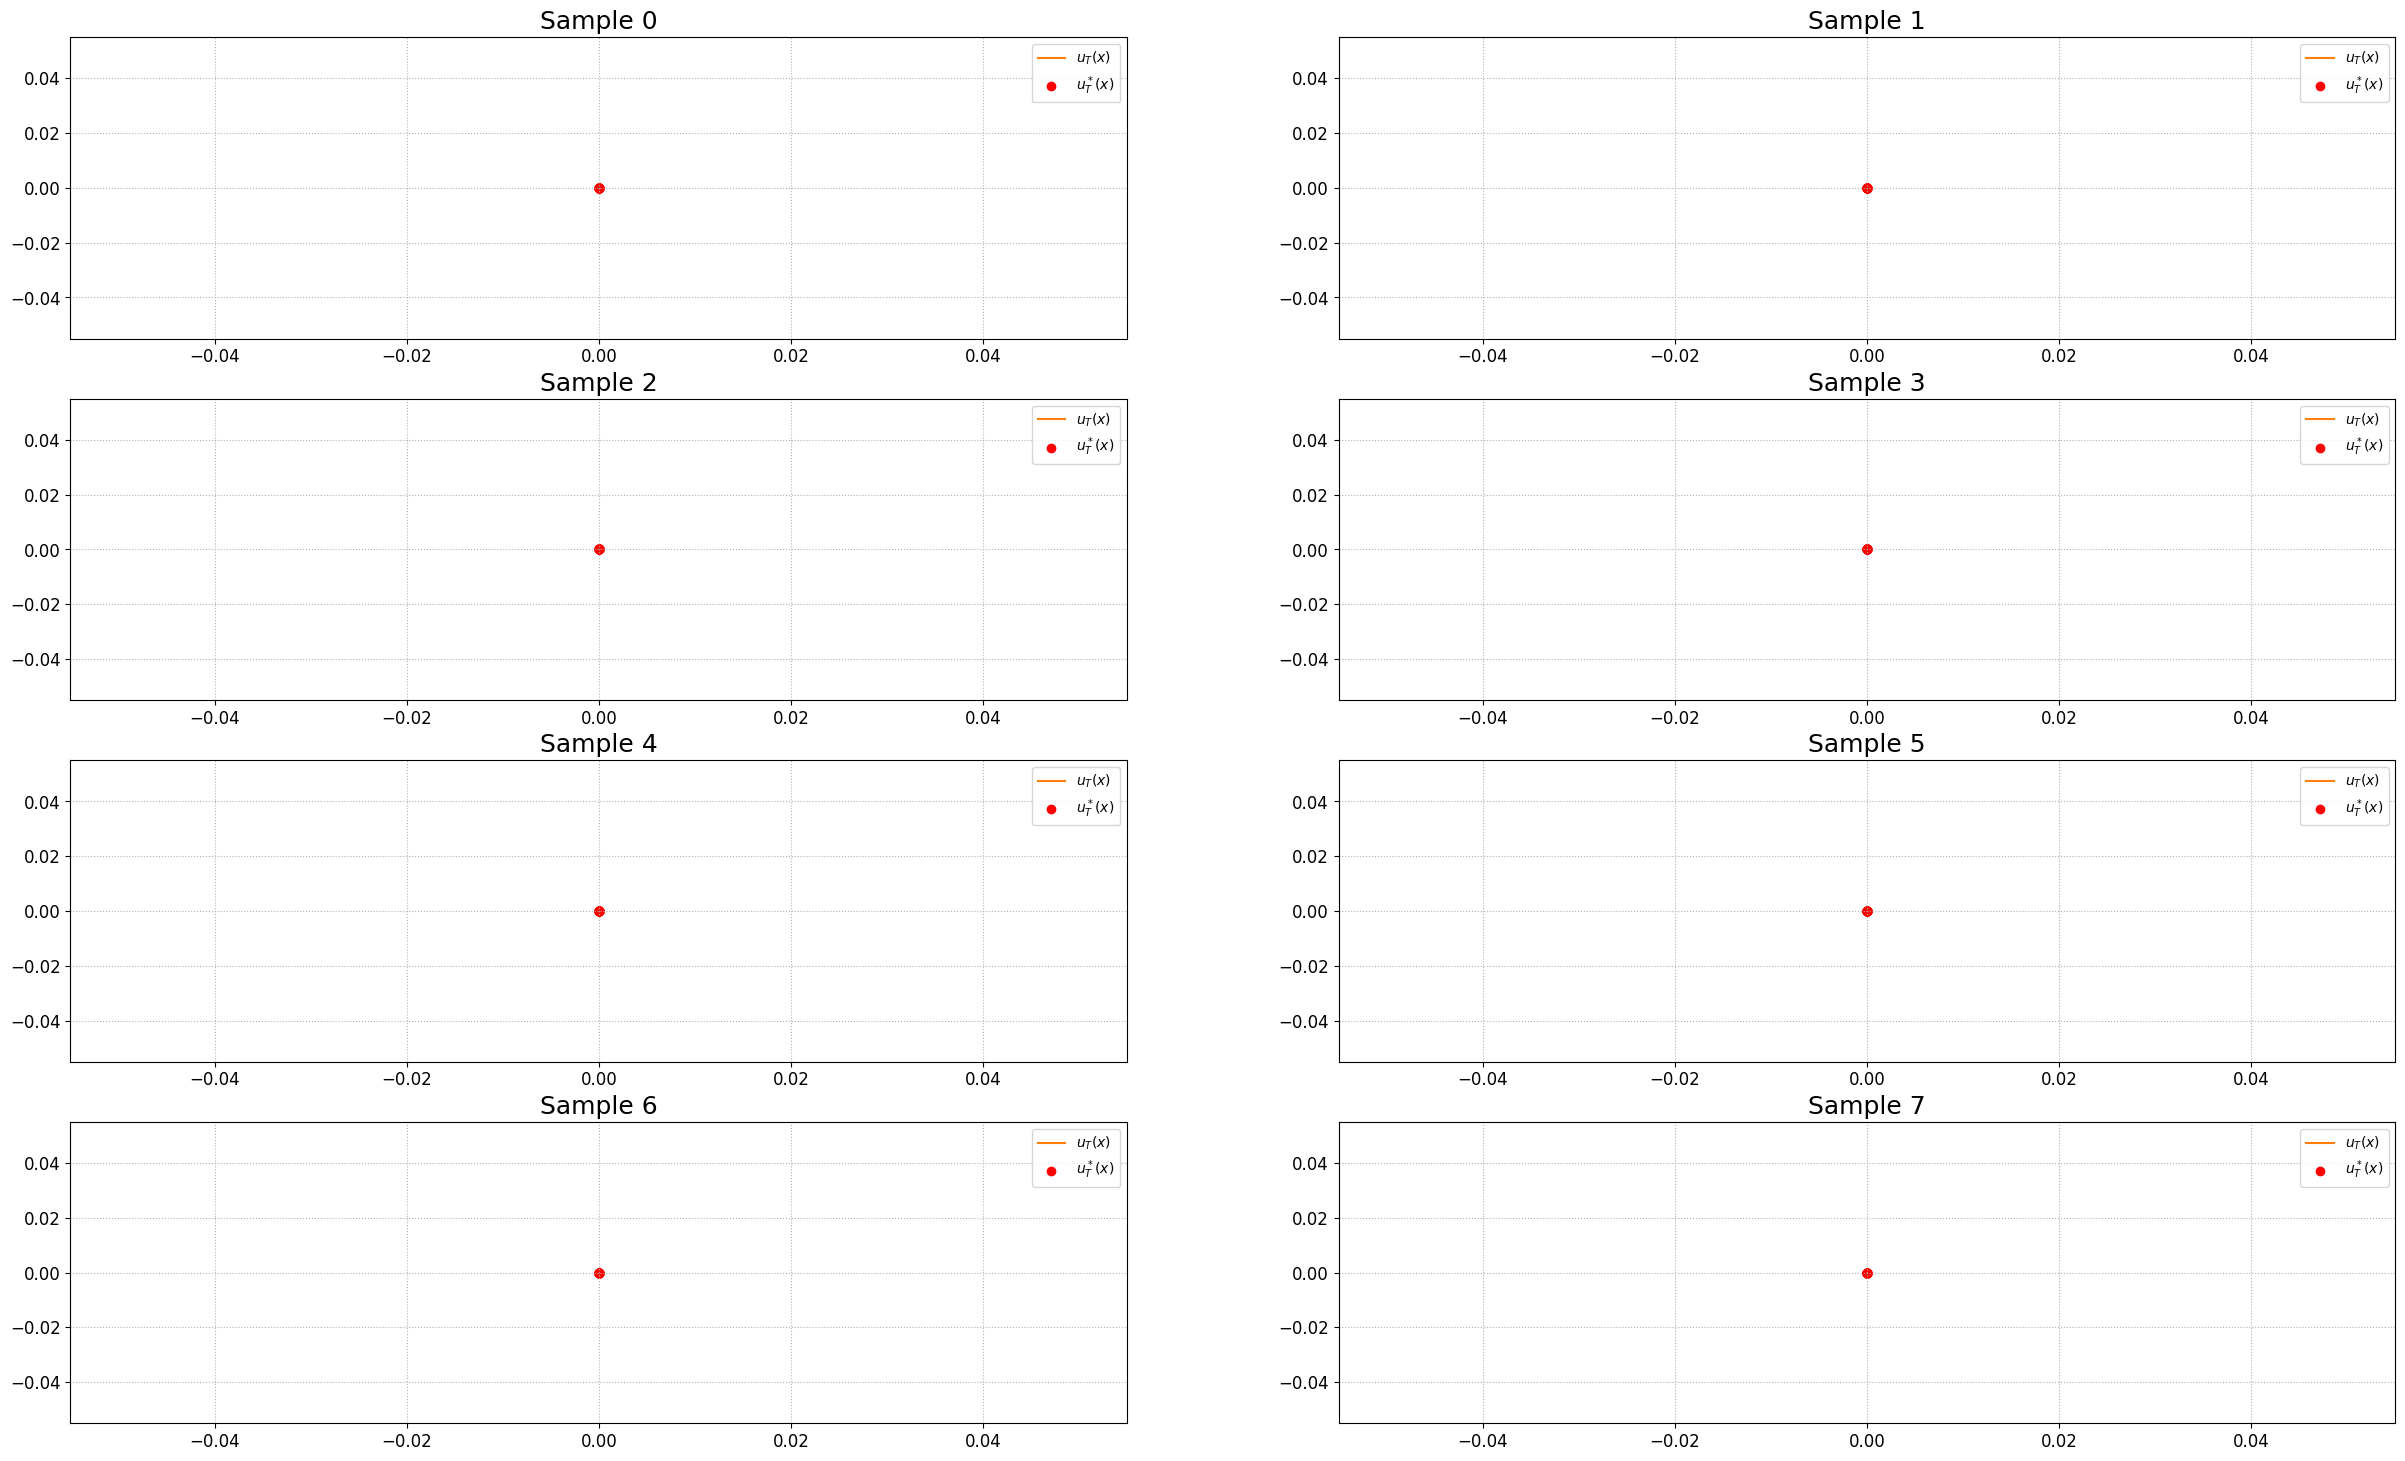

In [39]:
plot(donet_random,
     testing_set=random_testing_set_don,
     spatial_coordinates=grid_encoding_coordinates_donet)

In [40]:
# Train the model and plot some test samples
train(donet_grid,
      training_set=grid_training_set_don,
      testing_set=grid_testing_set_don,
      spatial_coordinates=grid_encoding_coordinates_donet)

ValueError: optimizer got an empty parameter list

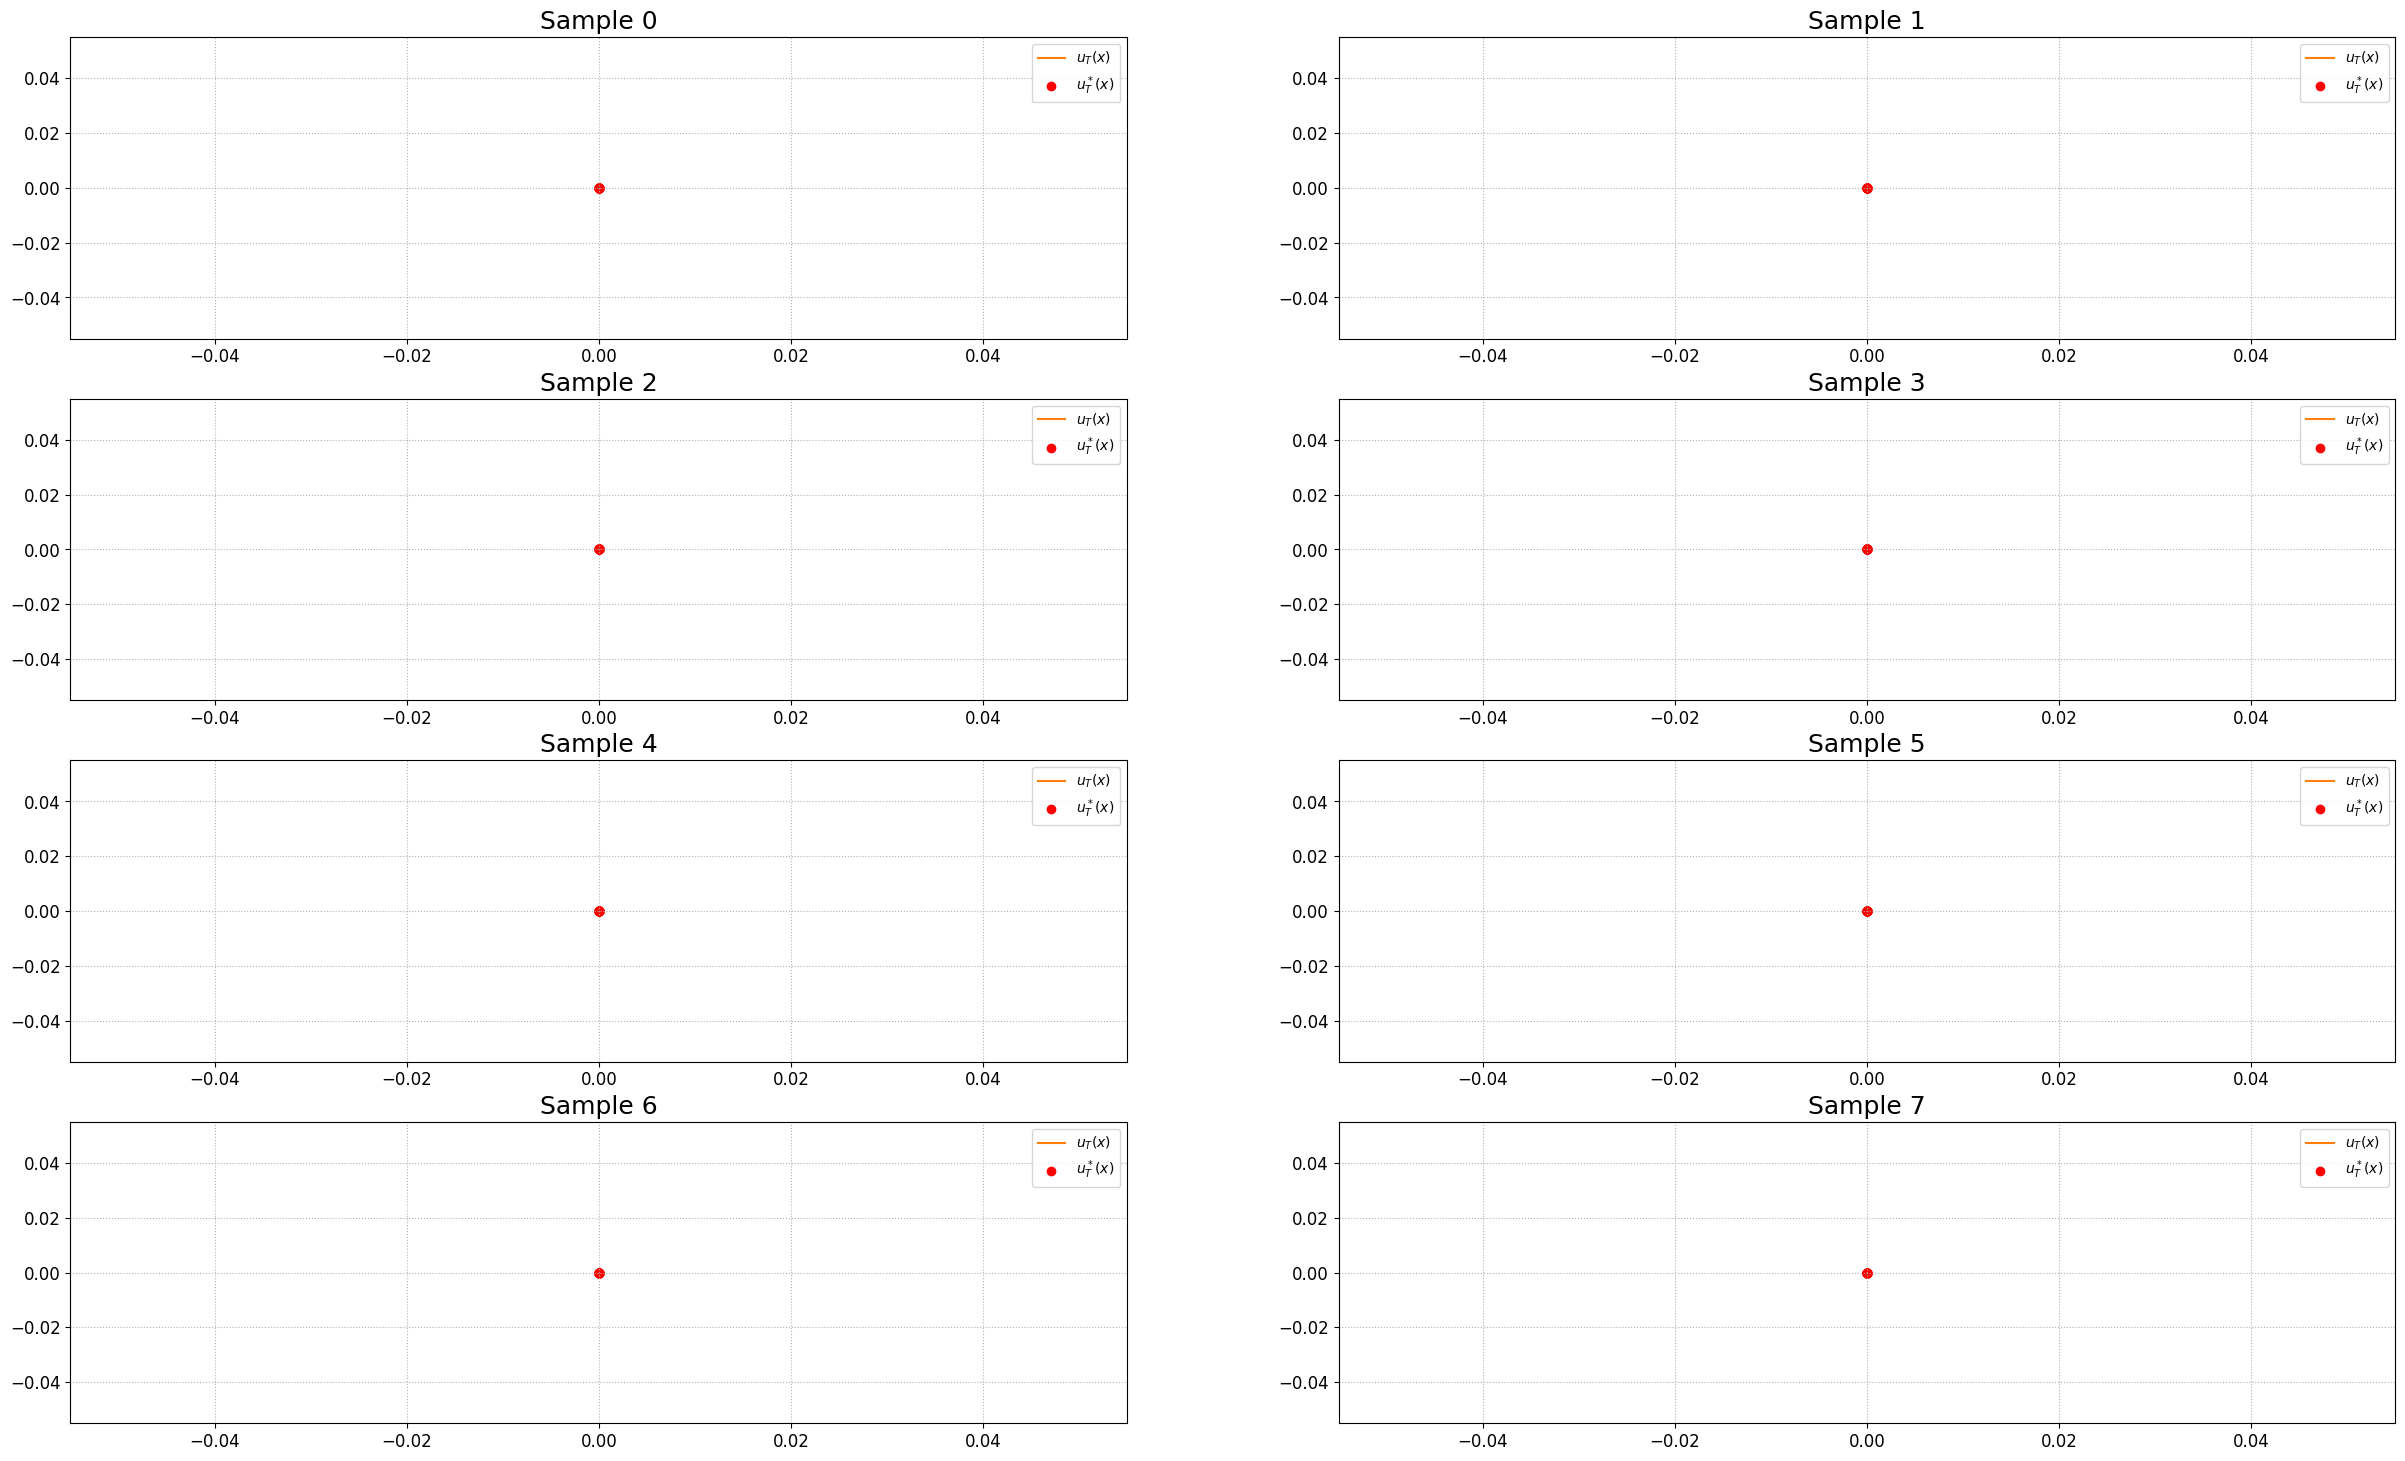

In [41]:
plot(donet_grid,
     testing_set=grid_testing_set_don,
     spatial_coordinates=grid_encoding_coordinates_donet)

In [42]:
# Train the model and plot some test samples
train(donet_fourier,
      training_set=fourier_training_set_don,
      testing_set=fourier_testing_set_don,
      spatial_coordinates=grid_encoding_coordinates_donet)

ValueError: optimizer got an empty parameter list

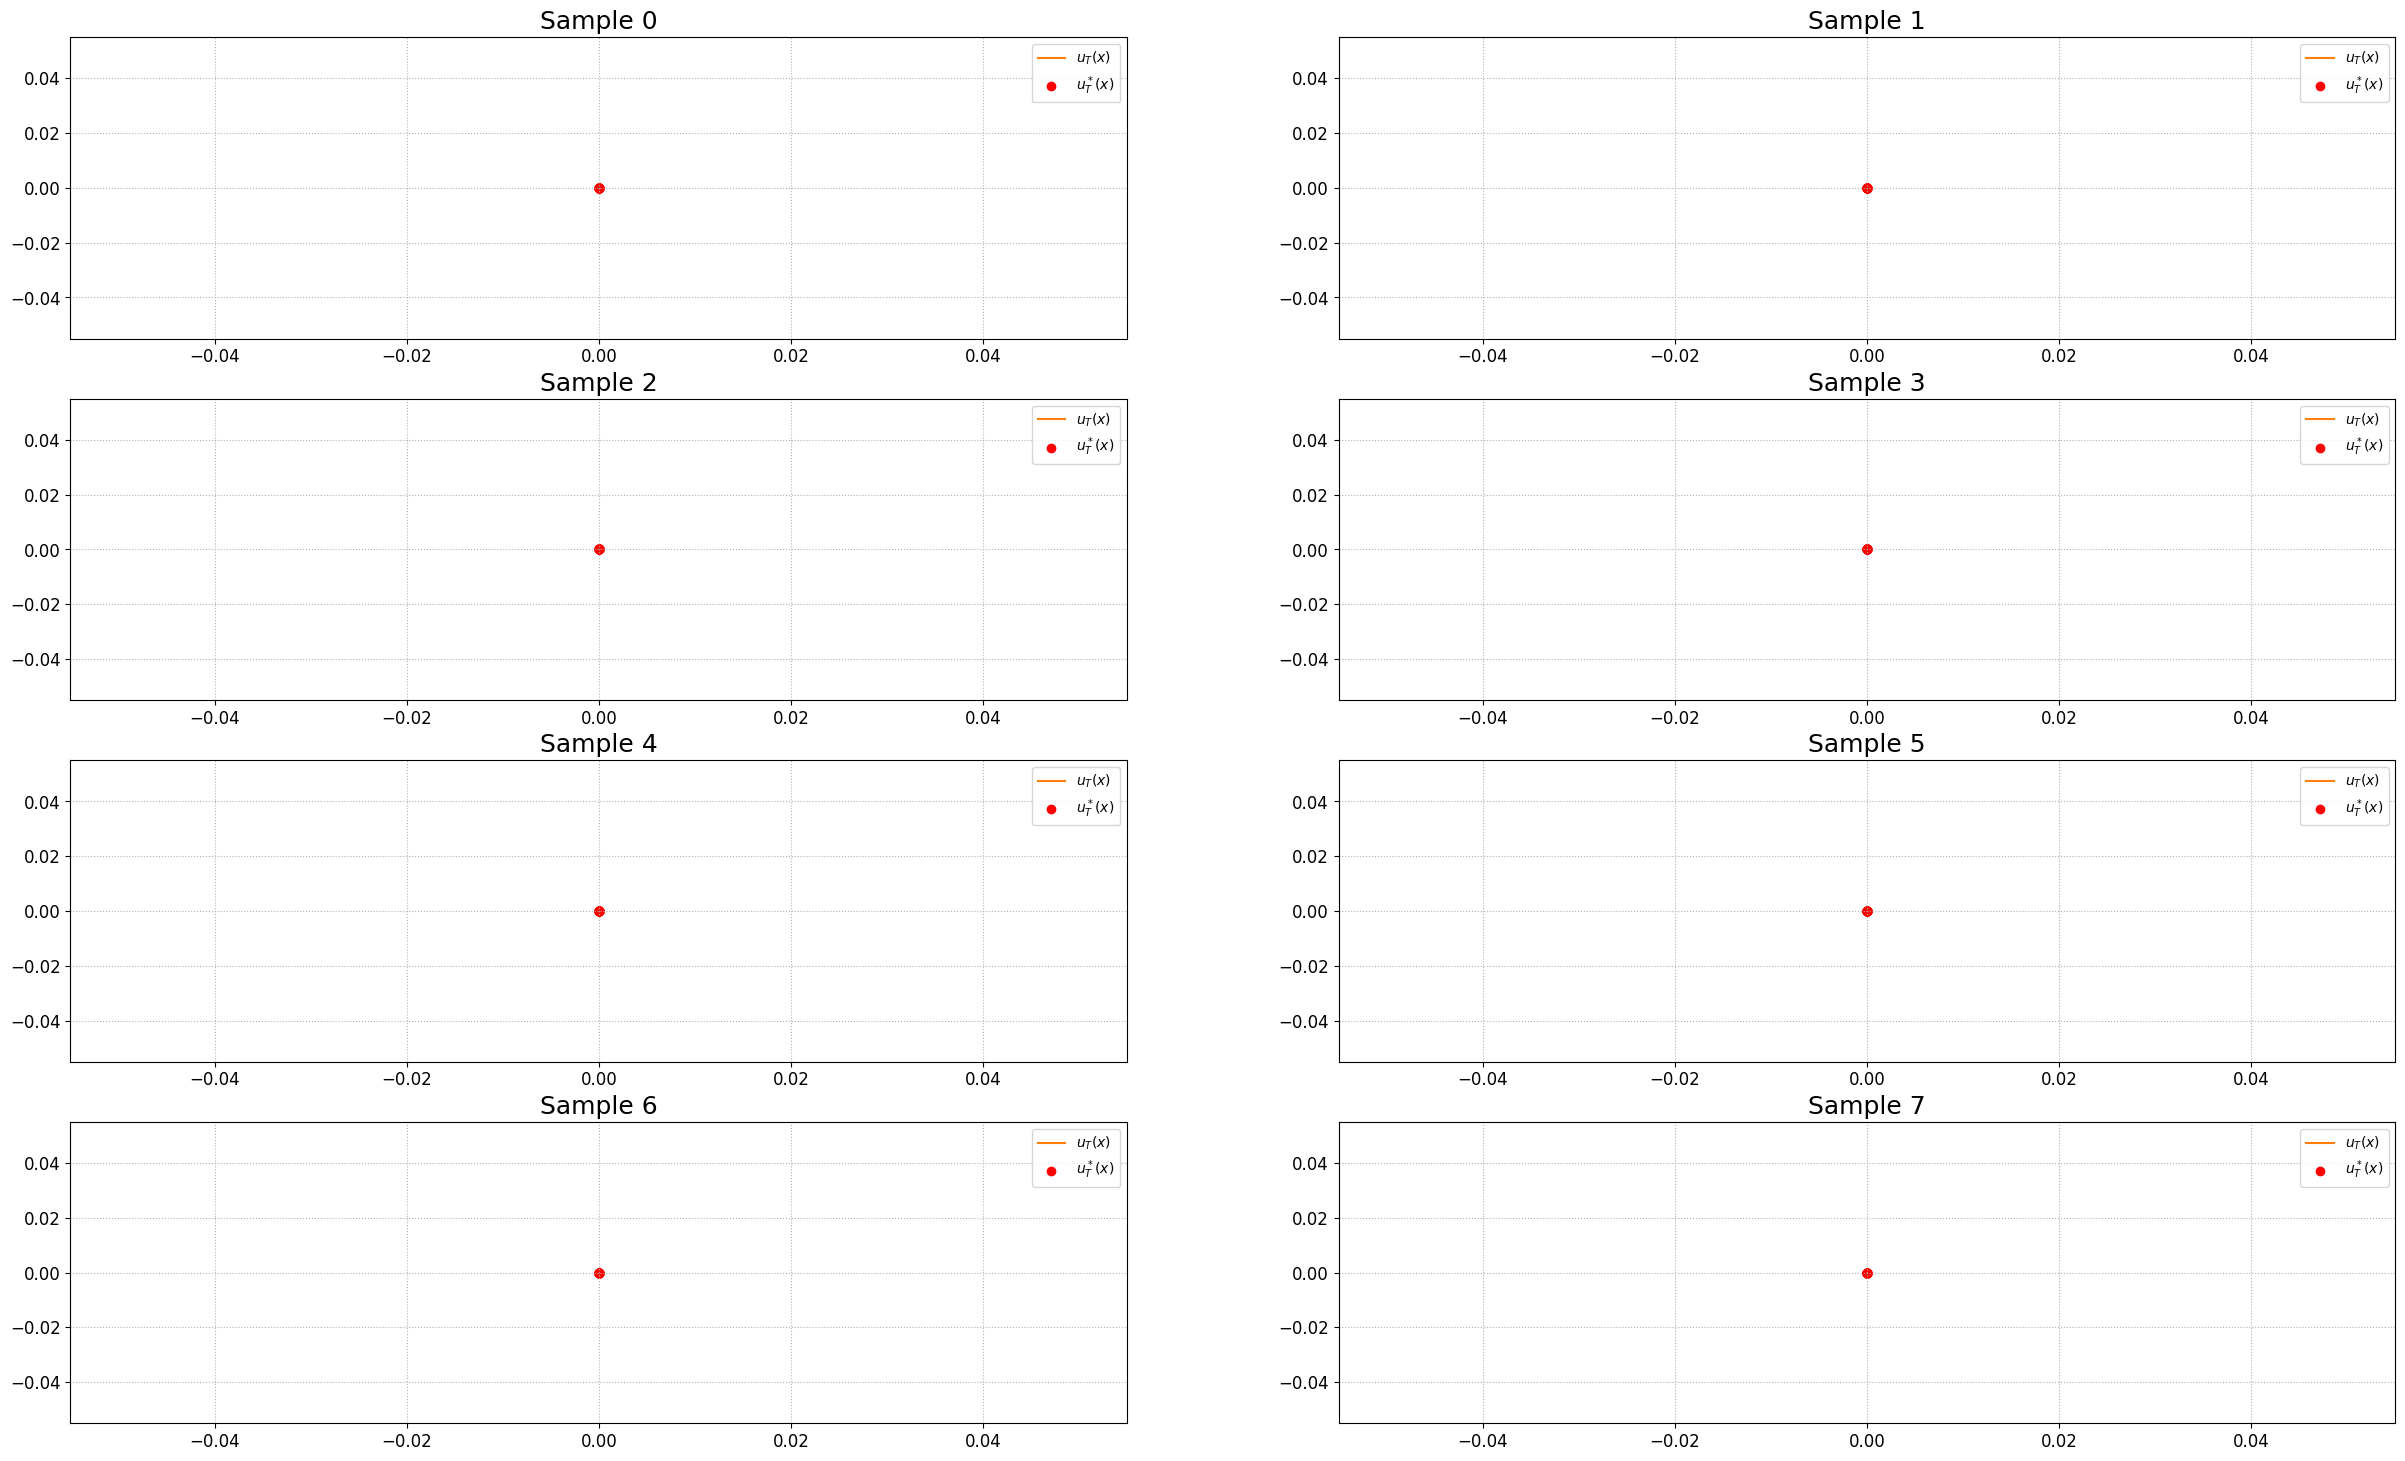

In [43]:
plot(donet_fourier,
     testing_set=fourier_testing_set_don,
     spatial_coordinates=grid_encoding_coordinates_donet)

In [44]:
# Train the model and plot some test samples
train(fno,
      training_set=training_set_fno,
      testing_set=testing_set_fno,
      spatial_coordinates=grid_encoding_coordinates_fno)

  0%|          | 0/500 [00:00<?, ?epoch/s]

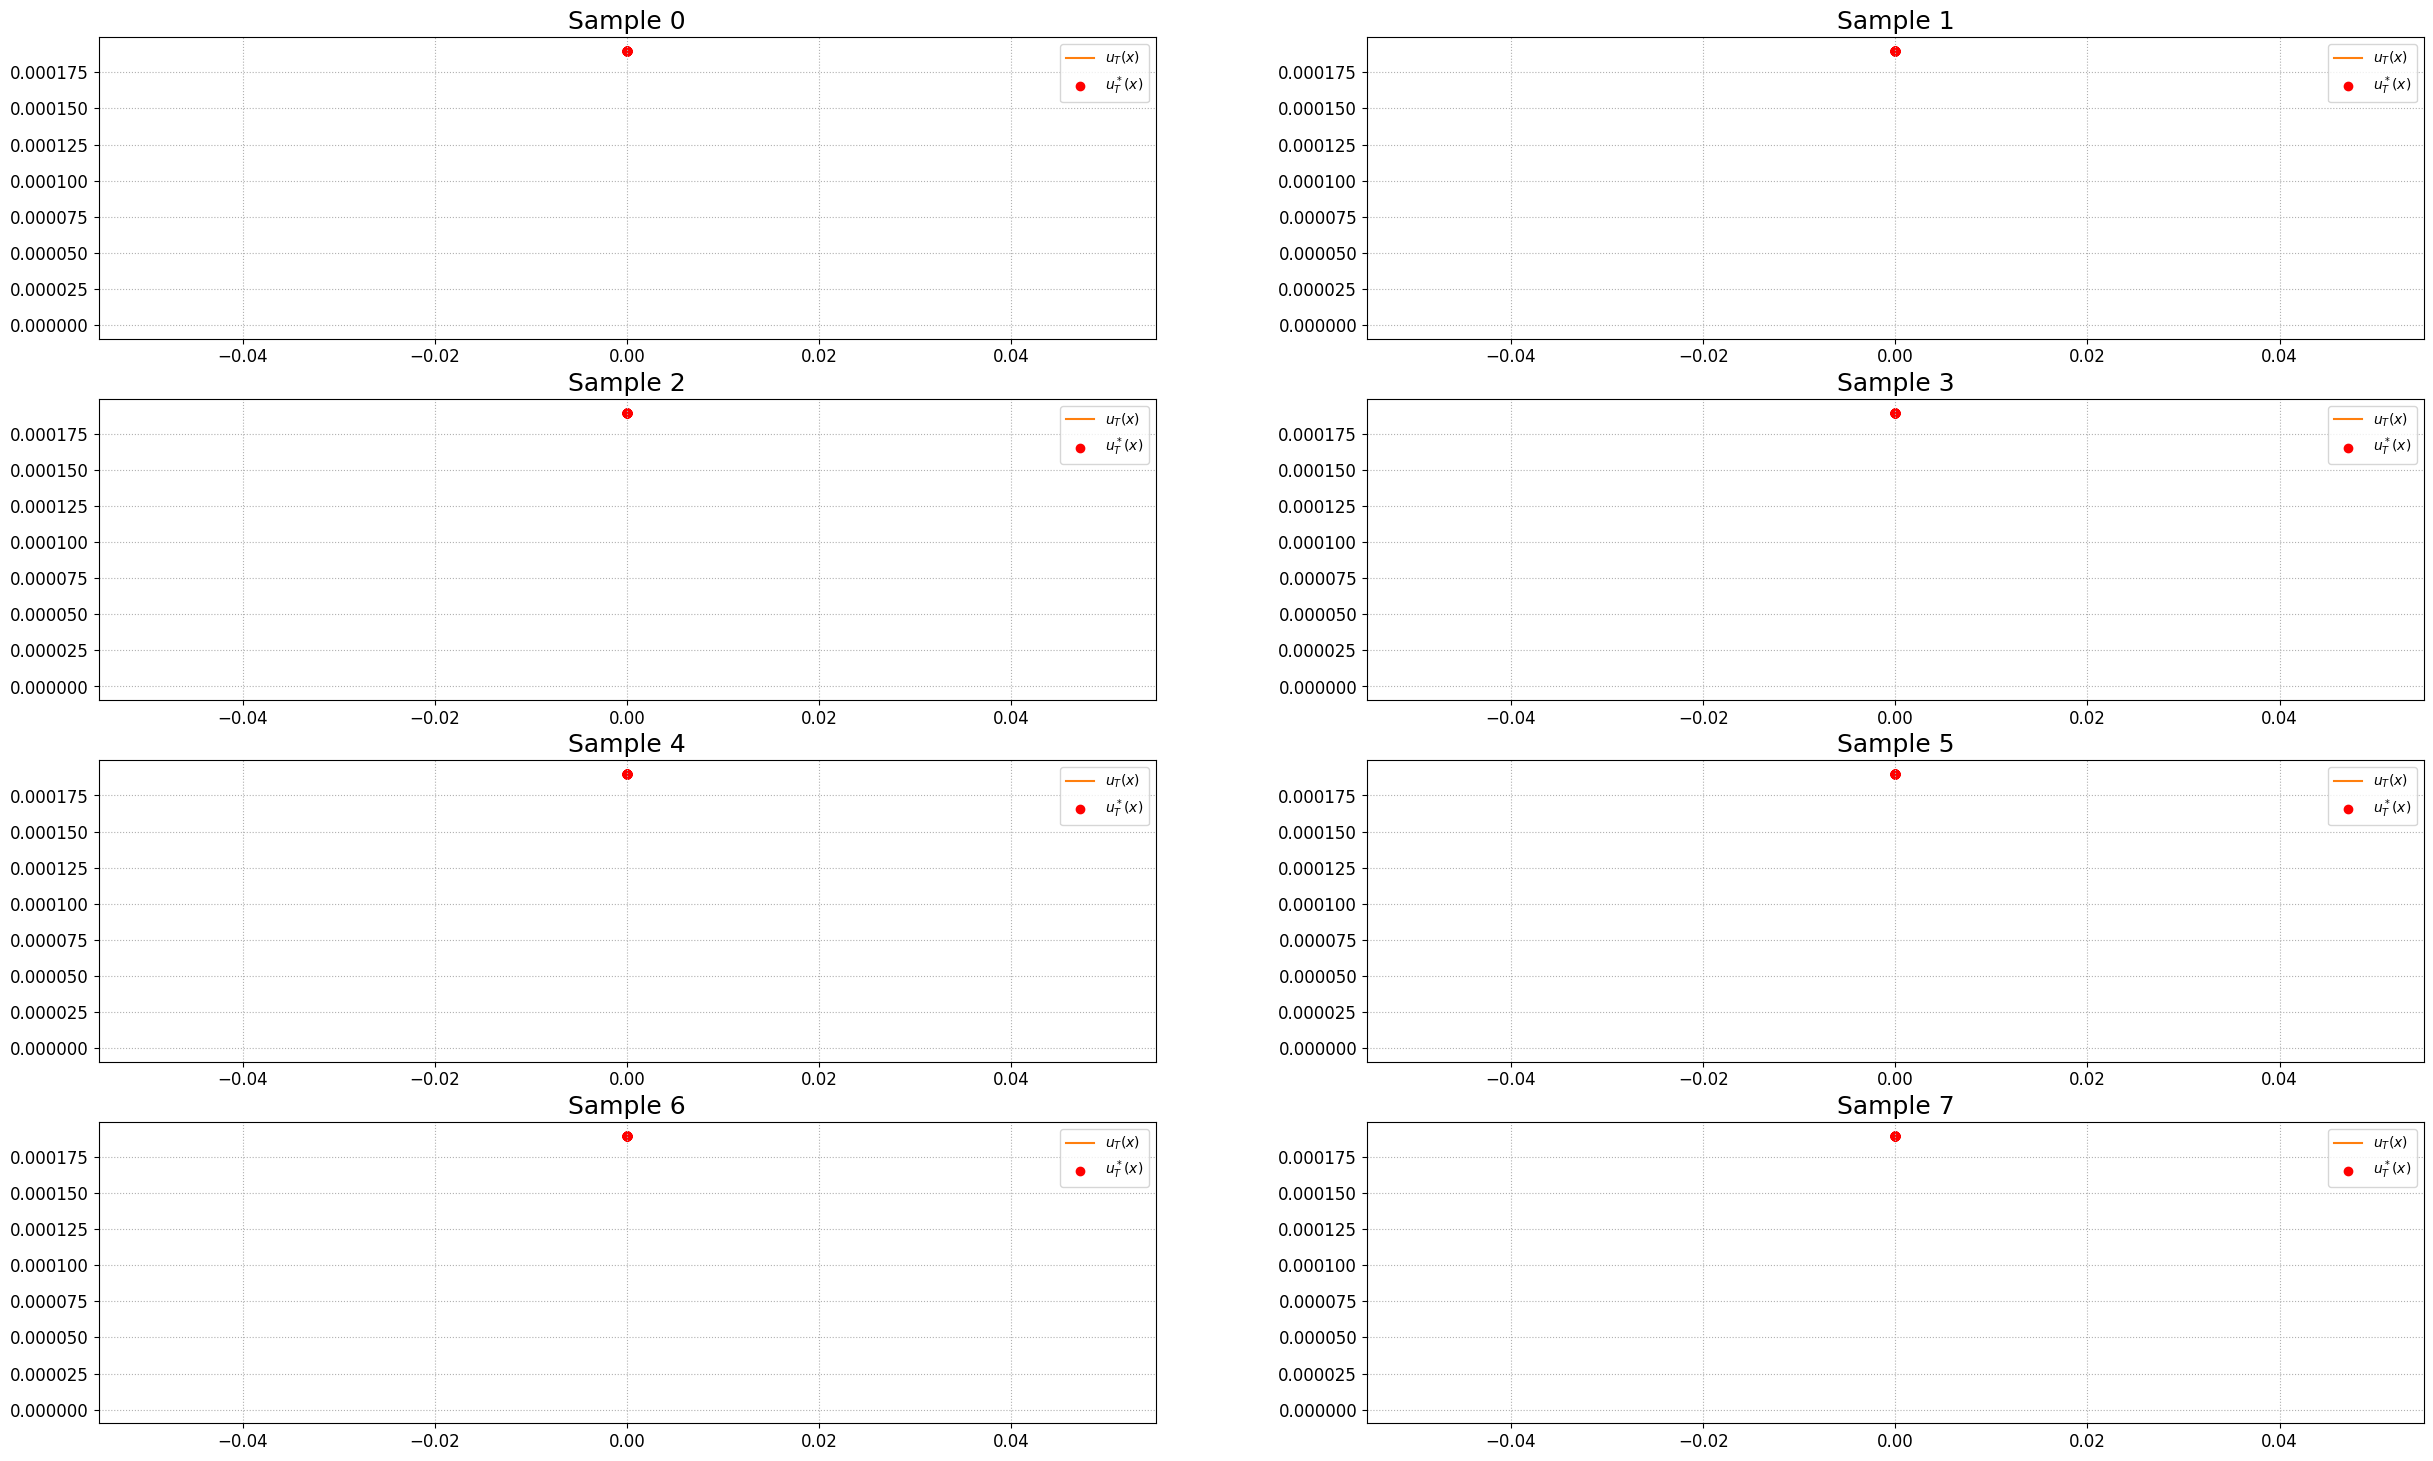

In [45]:
plot(fno,
     testing_set=testing_set_fno,
     spatial_coordinates=grid_encoding_coordinates_fno)

## Convolutional Neural Operator

[bogdanraonic3/ConvolutionalNeuralOperator](https://github.com/bogdanraonic3/ConvolutionalNeuralOperator)

## Neural Inverse Operator
[mroberto166/nio](https://github.com/mroberto166/nio)